# 라이브러리 import

In [2]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import re
import os
import zipfile
import pickle

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.style.use('seaborn')
sns.set(font_scale=1)

import warnings
warnings.filterwarnings('ignore')

from datetime import datetime
from tqdm import tqdm

# <데이터 준비 & 전처리>

# A. 뉴스데이터

# A-1 뉴스데이터 준비

## A-1-1. 뉴스데이터 Zip 파일 처리

In [2]:
def make_contents_from_zip():
    data_date = ['0406','0429','0506']
    for date in data_date:
        root = './data_raw/news_{}'.format(date)
        news_raw = pd.read_excel(root + '/3-1. NewsList.xls')
        
        file_name = news_raw['파일명'] #뉴스 리스트 파일에서 '파일명'만 따로 저장
        
        #zip 파일 압축 해제 -> news_contents_(날짜) 폴더에 저장
        zipfile.ZipFile(root + '/3-2. Contents.zip').extractall(root + '/news_contents_{0}'.format(date))
        
        # 모든 뉴스 텍스트를 (날짜)_news.txt로 합침.
        with open(root + '/{}_news.txt'.format(date), 'w') as outfile: 
            for fname in tqdm(file_name):
                with open(root + "/news_contents_{0}/{1}.txt".format(date,fname)) as infile: # 라인을 하나씩 가져와서 write.
                    for line in infile:
                        outfile.write(line)

In [3]:
make_contents_from_zip()

100%|██████████| 8786/8786 [00:00<00:00, 20632.09it/s]


## A-1-2. 뉴스데이터 기사내용 DataFrame화

In [4]:
def make_list(lst): # lst: ID를 기준으로 문자열을 나눈 리스트.

    ID = []
    Date = []
    Title = []
    Ariticle = []

    for i in tqdm(range(len(lst))):

        # index 정의
        id_index = lst[i].find("Date") # "Date" 이전까지를 ID로 저장.
        date_index_s = lst[i].find("Date") # date 시작 index
        date_index_e = lst[i].find("Title") - 1 # date 끝 index
        title_index_s = lst[i].find("Title") # title 시작 index
        title_index_e = lst[i].find("Ariticle") # title 끝 index

        ID.append(lst[i][:id_index].strip()) # 공백 제거 후 저장.
        Date.append(lst[i][date_index_s:date_index_e].strip())
        Title.append(lst[i][title_index_s:title_index_e].strip())
        Ariticle.append(lst[i][title_index_e:].strip())

    return ID, Date, Title, Ariticle

In [5]:
def make_news_df():
    data_date = ['0406','0429','0506'] 
    for date in data_date:
        root = './data_raw/news_{}'.format(date)

        news_list = pd.read_excel(root + '/3-1. NewsList.xls') #news list 준비
        with open(root + '/{}_news.txt'.format(date), "r") as f:
            news_text = f.read() #news text 모음 준비

        # id를 기준으로 전체 텍스트를 나눠서 list로 저장|.
        txt_splited_by_id = re.split("ID : [A-Z]{1}", news_text)
        txt_splited = txt_splited_by_id[1:] # 1번 ID 앞 문자 제외한 나머지 활용.
        
        ID, Date, Title, Article = make_list(txt_splited) #함수 적용
        
        #txt를 DataFrame으로 만들기
        columns = ['ID', 'Date', 'Title', 'Article']
        article_data = {'id': ID, 'date': Date, 'Title': Title, 'Article': Article}
        article_df = pd.DataFrame(article_data)
        
        #txt DataFrame 내용 정리(txt 중 'Date:', 'Title: ', 'Article:' 삭제)
        article_df['date'] = article_df['date'].apply(lambda x: x[7:])
        article_df['Title'] = article_df['Title'].apply(lambda x: x[8:])
        article_df['Article'] = article_df['Article'].apply(lambda x: x[11:])
        
        
        #news_list에 기사내용 삽입
        news_list['기사내용'] = article_df['Article'].apply(lambda x: x.strip())
        
        print('날짜_{}에 게시된 뉴스데이터 데이터프레임 저장됨'.format(date))
        news_list.to_pickle('./data_processed/A.News/news_df_{}.pkl'.format(date))

In [6]:
make_news_df()

100%|██████████| 61725/61725 [00:00<00:00, 166371.33it/s]


날짜_0406에 게시된 뉴스데이터 데이터프레임 저장됨


100%|██████████| 42105/42105 [00:00<00:00, 238465.58it/s]


날짜_0429에 게시된 뉴스데이터 데이터프레임 저장됨


100%|██████████| 8786/8786 [00:00<00:00, 250299.91it/s]

날짜_0506에 게시된 뉴스데이터 데이터프레임 저장됨


## A-1-3. 뉴스데이터 하나의 DataFrame으로 합치기

In [7]:
def make_news_df():
    data_date = ['0406','0429','0506'] 
    covid_concat = pd.DataFrame()
    
    for date in data_date:
        #news dataframe 읽어서 Covid 뉴스만 저장
        news_df = pd.read_pickle('./data_processed/A.News/news_df_{}.pkl'.format(date))
        news_covid = news_df[news_df['감염병명'] == 'COVID-19'].copy()
        
        news_covid.rename(columns = {'게시일자':'게시날짜'}, inplace=True)
        news_covid['게시날짜'] = pd.to_datetime(news_covid['게시날짜'], format="%Y-%m-%d")
        
        covid_concat = pd.concat([covid_concat, news_covid]).reset_index(drop=True)
                                 
    return covid_concat

In [8]:
def clean_datetime_then_sort(dataframe, date_col):
    from datetime import datetime
    #날짜 중 년-월-일만 사용
    dataframe[date_col] = dataframe[date_col].apply(lambda x: datetime.strptime(datetime.strftime(x, "%Y-%m-%d"), "%Y-%m-%d"))
    
    #날짜 기준 Sorting
    dataframe_sorted = dataframe.sort_values(date_col).reset_index(drop=True)
    
    return dataframe_sorted

In [9]:
#각각의 뉴스데이터 df를 하나로 합침
covid_concat = make_news_df()
covid_concat_sorted = clean_datetime_then_sort(covid_concat, '게시날짜')

#2020-01-01 이후 데이터만 사용
covid_dropped = covid_concat_sorted[covid_concat_sorted['게시날짜'] > '2020-01-01']
covid_dropped.reset_index(drop=True, inplace=True)

#pickle 파일로 저장
covid_dropped.to_pickle('./data_processed/A.News/covid_news_entire.pkl')

## A-1-4. Garbage Data 삭제
- 기사내용에 'the'가 1개 이하로 나오는 데이터는 영어가 아닌 데이터이거나 기사 내용이 너무 짧은 데이터라 판단하여 Garbage로 정의. 삭제하도록 한다.

In [10]:
#하나로 합쳐진 데이터 불러오기
covid_entire = pd.read_pickle('./data_processed/A.News/covid_news_entire.pkl')

In [11]:
#'the'를 기준으로 garbage 데이터 찾기
import re
garbage_idx = []
for idx, txt in enumerate(covid_entire['기사내용']):
    find_the = re.findall('the', txt)
    if len(find_the) < 2:
        garbage_idx.append(idx)
print(len(garbage_idx))

28467


In [12]:
covid_garbage_dropped = covid_entire.drop(garbage_idx)
covid_garbage_dropped.reset_index(drop=True, inplace=True)

In [13]:
covid_garbage_dropped.to_pickle('./data_processed/A.News/covid_news_wo_garbage.pkl')

# A-2. 뉴스 데이터 전처리

In [14]:
#뉴스 데이터 불러오기
covid_pure = pd.read_pickle('./data_processed/A.News/covid_news_wo_garbage.pkl')

## A-2-1. 단어 통일하기 위한 딕셔너리 생성

In [15]:
dict_change_word= {'coronavirus':'COVID', 'corona virus':'COVID', 'covid':'COVID','Mers-CoV':'MERSCOV', 'MERS-COV' :'MERSCOV', 'MERS-CoV':'MERSCOV', 'South Korea':'SOUTHKOREA', 'Republic of Korea':'SOUTHKOREA', 'korea':'SOUTHKOREA',
                   'human-to-human' : 'persontoperson', 'person-to-person' : 'persontoperson', 'Human-to-human' :'persontoperson', 'Person-to-person':'persontoperson', 
                   'people-to-people':'persontoperson', 'animal-to-human': 'animaltohuman','animal-to-person': 'animaltohuman', 'human-to-animal' : 'humantohuman', 
                   'stay-at-home' : 'stayathome', 'work-from-home' : 'workfromhome', 'face-to-face': 'face2face', 'case-by-case':'casebycase','hand-washing':'handwashing',
                   'year-old':'yearold', 'years old':'yearold'}
dict_change_country = {'New York' : 'NEWYORK', 'United Kingdom' : 'UNITEDKINGDOM', 'us-' : 'US', '-us' :'US', 'usa' :'US', 'Hong Kong' : 'HONGKONG', 'New Zealand':'NEWZEALAND','Saudi Arabia':'SAUDIARABIA', 'SAUDI ARABIA':'SAUDIARABIA'}

In [16]:
#각 주를 upper 시키고 하나로 합치는 과정(eg. British Columbia -> BRITISHCOLUMBIA)
province = pd.read_pickle('./data_raw/province_df.pkl')
province_df = pd.DataFrame(province.values, columns=['province'])
province_df['new_col'] = province_df['province'].apply(lambda x : x.replace(' ','').upper())

#딕셔너리 형태로 만들어준다.
dict_country = {}
for k, v in zip(province_df['province'], province_df['new_col']):
    dict_country[k] = v

#단어 통일을 위한 딕셔너리 업데이트 - 결과물 통합: dict_change_word
dict_change_country.update(dict_country)
dict_change_word.update(dict_change_country)

## A-2-2. 딕셔너리를 이용한 단어 변경 & 소문자로 변환 함수

In [17]:
#dict_change_word에 해당하는 단어를 변경하는 함수
def change_hiphen_word(text, dictionary):
    com_list = [".replace('{}', '{}')".format(word, dictionary[word]) for word in dictionary.keys() if word in text]
    com_list.insert(0, "'{}'.format(text)")
    command = ''.join(com_list)
    text = eval(command)

    return text

In [18]:
#모든 문자가 대문자(eg.WHO)인 단어를 제외한 대문자가 포함된 단어(eg.Who)를 소문자로 변환
def lower_text(text_list):
    
    import re
    print("\nThis is lower() process.\n")
    for series_idx, text in tqdm(enumerate(text_list)): # Series에 있는 각 text.
        for idx, word in enumerate(text): # text에 있는 각 word.
            text[idx] = re.sub("[A-Z]{1}[a-z]+", word.lower(), word)
        
        text_list[series_idx] = text # lower()를 적용시킨 text를 저장.

    return text_list

## A-2-3. 단어 처리+Tokenize

In [19]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

[nltk_data] Downloading package punkt to /home/mladmin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/mladmin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [20]:
def to_tokenize(text_Series, dict_change_word): # input은 '기사내용'을 pd.Series 타입으로 줌. out도 Series 타입.
    import re

    # 1. URL 부분 제거.
    print("\nURL 제거 과정.\n")
    text_Series = [re.sub('((http(s?))\:\/\/)([0-9a-zA-Z\-]+\.*\/*(\\n)*)+|url|URL', '', text) for text in tqdm(text_Series)]

    # 2. e-mail 주소 제거.
    print("\ne-mail 제거 과정.\n")
    text_Series = [re.sub('(\<.[a-zA-Z0-9._%+-]+)@([a-zA-Z0-9.-]+)(\.[a-zA-Z]{2,4})', '', text) for text in tqdm(text_Series)] 

    # 3. 하이픈 붙은 단어 변경
    print("\n하이픈 단어 변경 과정.\n")
    #text_Series = text_Series.apply(lambda x: change_hiphen_word(x, dict_change_word))
    text_Series = [change_hiphen_word(text, dict_change_word) for text in tqdm(text_Series)]
    
    # 4. 특수문자 제거. 모두 제거.
    print("\n특수문자 제거 과정.\n")
    text_Series = [re.sub('[-=+,#/\?:^$.@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》]', ' ', text) for text in tqdm(text_Series)]

    # 5. 문자 외 모두 제거(공백, \, 숫자 사라짐)
    print("\n문자 외 제거 과정.\n")
    text_Series = [re.sub('[^a-zA-Z]', ' ', text) for text in tqdm(text_Series)]

    # 6. 각 text를 tokenize 한다.
    print("\nTokenize 과정.\n")
    text_Series_tokenized = [word_tokenize(text) for text in tqdm(text_Series)]

    # 6. 앞 글자 대문자 lower()
    print("\n대소 변환 과정. \n")
    text_Series_tokenized_lower = lower_text(text_Series_tokenized)

    return text_Series_tokenized

In [21]:
covid_after_tokenize = to_tokenize(covid_pure['기사내용'], dict_change_word)

  2%|▏         | 978/53299 [00:00<00:05, 9770.53it/s]


URL 제거 과정.



  0%|          | 0/53299 [00:00<?, ?it/s]


e-mail 제거 과정.


하이픈 단어 변경 과정.



  3%|▎         | 1859/53299 [00:00<00:02, 18583.24it/s]


특수문자 제거 과정.



  1%|          | 621/53299 [00:00<00:08, 6203.65it/s]


문자 외 제거 과정.



  0%|          | 47/53299 [00:00<01:58, 449.31it/s]


Tokenize 과정.



100%|██████████| 53299/53299 [01:50<00:00, 482.37it/s]
192it [00:00, 1918.12it/s]


대소 변환 과정. 


This is lower() process.



53299it [00:31, 1688.13it/s]


In [22]:
#tokenize 이후 데이터 저장
with open("./data_processed/A.News_preprocessed/covid_after_tokenize.pkl", 'wb') as f:
    pickle.dump(covid_after_tokenize, f)

## A-2-4. Stopword

In [23]:
#Tokenize 완료된 데이터 불러오기
with open("./data_processed/A.News_preprocessed/covid_after_tokenize.pkl", 'rb') as f:
     covid_after_tokenize = pickle.load(f)

In [24]:
from nltk.corpus import stopwords
import nltk

nltk.download('stopwords')
stopword = stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/mladmin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [25]:
#Stopword에 추가할 리스트
my_stopwords = ['jsp', 'jpg', 'htm', 'trto', 'trfr', 'video', 'modernizr','videovideopinner','videoplayervideoplayer', 'containercontainerid','www', 'com',
                'case', 'new', 'country', 'yearold','state', 'also', 'city', 'county', 
                'year', 'january', 'febuary', 'february', 'feb', 'mar', 'march', 'april', 'apr', 
                'week',  'day', 'sunday','monday','tuesday','wednesday','thursday','friday','saturday',
                'number', 'first', 'one', 'two', 'three','million', 'time', 'official', 'way','since',
                'accord',  'news', 'CNN', 'EDR', 'PRO','AH', 'reuters', 'photo', 'CCTV','xinhua',
                'south', 'total', 'united', 'person', 'human', 'people', 'health',
                'showarticle', 'docdocid', 'department', 
                'A','B','C','D','E','F','G','H','I','J','K','L','M', 'N', 'O', 'P','Q','R','S','T','U','V','W','X','Y','Z',
                'COVID', 'covid']

my_stopwords_verb = ['would','take', 'say','could', 'may', 'report', 'quot','include','come','need', 'use', 'tell', 
                                 'show', 'many','get', 'know', 'like', 'make', 'return',
                                 'call', 'add', 'follow', 'see', 'man', 'go','help', 'must', ]

stopword = set(stopword + my_stopwords + my_stopwords_verb)

In [26]:
#(문자가 2개 초과 & 14개 미만으로 구성된 단어)이거나 (모든 문자가 대문자(eg. WHO))인 단어 보관
covid_after_stopword = [[word for word in word_list if ((len(word) > 2) & (len(word) < 14)) | (word.isupper())] for word_list in tqdm(covid_after_tokenize)]

#stopword에 없는 단어 보관
covid_after_stopword = [[word for word in word_list if word not in stopword] for word_list in tqdm(covid_after_stopword)]

100%|██████████| 53299/53299 [00:03<00:00, 13410.22it/s]


In [27]:
#stopword 적용 이후 데이터 저장
with open("./data_processed/A.News_preprocessed/covid_after_stopword.pkl", 'wb') as f:
    pickle.dump(covid_after_stopword, f)

## A-2-4. Lemmatization

In [28]:
import nltk

In [29]:
#stopword 적용된 데이터 불러오기
with open("./data_processed/A.News_preprocessed/covid_after_stopword.pkl", 'rb') as f:
    covid_after_stopword = pickle.load(f)

In [30]:
from nltk.tag import pos_tag
from tqdm import tqdm
nltk.download('averaged_perceptron_tagger')

#태깅되어있는 tag 값을 lemmatizer가 알 수 있도록 변경.
def tagging(tagged_words): 

    tagged_words = pos_tag(tagged_words)

    for idx, (word, tag) in enumerate(tagged_words):
            if (tag == 'VBP') | (tag == 'VBG') | (tag == 'VBD') | (tag == 'VBZ') | (tag == 'VBN'):
                tagged_words[idx] = (word, 'v')
            elif (tag == 'RB') | (tag == 'JJ'):
                tagged_words[idx] = (word, 'a')
            else:
                tagged_words[idx] = (word, 'n')

    return tagged_words # 태깅된 요소 반환.

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/mladmin/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [31]:
#전체 기사내용에 대해 태깅작업 실시
def tagging_transform(tagged_list):
    tagged_list = [tagging(words_list) for words_list in tqdm(tagged_list, mininterval=3)]
    return tagged_list

In [32]:
covid_tagged = tagging_transform(covid_after_stopword) # pos 값 변환.

100%|██████████| 53299/53299 [11:39<00:00, 76.25it/s]


In [33]:
#tagging 한 단어 리스트로 표제어를 추출
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

lemmatizer = WordNetLemmatizer()
covid_lemmatized = [[lemmatizer.lemmatize(word, tag) for word, tag in words_list] for words_list in tqdm(covid_tagged)]

[nltk_data] Downloading package wordnet to /home/mladmin/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
100%|██████████| 53299/53299 [00:55<00:00, 961.75it/s] 


In [34]:
#stopword 다시 실행 - verb에서 지워지지 않은 단어들이 있다. 
covid_lemmatized_stopword = [[word for word in word_list if word not in stopword] for word_list in tqdm(covid_lemmatized)]

100%|██████████| 53299/53299 [00:01<00:00, 34016.14it/s]


In [35]:
#lemmatize 이후 데이터 저장
with open("./data_processed/A.News_preprocessed/covid_lemmatized_stopword.pkl", 'wb') as f:
    pickle.dump(covid_lemmatized_stopword, f)

In [36]:
with open("./data_processed/A.News_preprocessed/covid_lemmatized_stopword.pkl", 'rb') as f:
    covid_lemmatized_stopword = pickle.load(f)

In [37]:
covid_garbage_dropped = pd.read_pickle('./data_processed/A.News/covid_news_wo_garbage.pkl')
covid_garbage_dropped['기사내용'] = covid_lemmatized_stopword
covid_ready_for_LDA = covid_garbage_dropped

#covid 전체 데이터프레임 ['기사내용']에 전처리 완료된 데이터 저장
covid_ready_for_LDA.to_pickle('./data_processed/A.News_preprocessed/covid_ready_for_LDA.pkl')

# B. 국외 코로나 발생현황 데이터
### '해외감염병 now' 홈페이지로부터 크롤링
- 출처: http://xn--now-po7lf48dlsm0ya109f.kr/

# B-1. 국외 코로나 발생현황 데이터 준비

In [38]:
!pip install bs4

## B-1-1 크롤러 만들기

In [39]:
# 웹페이지로부터 국가별 확진자수 데이터프레임 생성하는 함수 정의
def make_df(table):

    rows = []
    category = {}
    case = {}
    row = {}

    num_of_col = len(table.find_all('tr')[1].find_all('td')) #표 형식 표현(colum이 몇개인지 확인)
    for tr in table.find_all("tr")[1:]: # 표 형식에서 국가와 확진자수 각각 수집
        tds = tr.find_all("td")   
        country = []
        row_case_death_num = []

        if (len(tds) == num_of_col) and len(tds) == 2 :
            for td in tds:
                text = td.find('p').span.text

                if bool(re.match('\D+', text)):
                    country.append(text) # 발생 국가 수집
                else:
                    splited_txt_list = text.split('(')
                    text = int(splited_txt_list[0].replace(',', '').strip())
                    row_case_death_num.append(text) # 발생 확진자수 수집

        elif len(tds) == num_of_col :
            cat = tds[0].find('p').span.text
            if 'rowspan' in tds[0].attrs:
                rowspan_size = int(tds[0].attrs['rowspan'])
            else: rowspan_size = 1
            category[cat] = rowspan_size

            for td in tds[1:]:
                text = td.find('p').span.text

                if bool(re.match('\D+', text)):
                    country.append(text) # 발생 국가 수집
                else:
                    splited_txt_list = text.split('(')
                    text = int(splited_txt_list[0].replace(',', '').strip())
                    row_case_death_num.append(text) # 발생 확진자수 수집
        else: 
            for td in tds:
                text = td.find('p').span.text

                if bool(re.match('\D+', text)):
                    country.append(text) # 발생 국가 수집
                else:
                    splited_txt_list = text.split('(')
                    text = int(splited_txt_list[0].replace(',', '').strip())
                    row_case_death_num.append(text) # 발생 확진자수 수집
        row[country[0]] = row_case_death_num

    return(row, category)

# 데이터프레임이 해당되는 날짜 정보 수집
def get_only_date(page_url):
    tmp = soup_2.find_all('b')
    tmp2 = re.findall('\s\d.\d{1,2}일\s',str(tmp)) # 페이지 내에서 날짜 정보 찾기
    if tmp2 == []:
        tmp_p = soup_2.find_all('p') # 날짜의 class 형식이 다른 경우 날짜 정보 찾는 법
        tmp3  = re.findall('\d\.\d{1,2}일', str(tmp_p))

        tmp3 = list(set(tmp3)) # 크롤링한 날짜 리스트 생성
        tmp2.append(tmp3)
        get_date_2 = re.findall('\d.\d{1,2}',str(tmp3))
        return get_date_2

    else:
        get_date_2 = re.findall('\d.\d{1,2}',str(tmp2)) # 페이지 내에서 날짜 정보 찾기
        return get_date_2

## B-1-2. 크롤링 실행

In [40]:
from urllib.request import urlopen
from bs4 import BeautifulSoup
import urllib.request


# 크롤링할 해외감염병 발생 소식 url
url_page_head = 'http://xn--now-po7lf48dlsm0ya109f.kr/infect/occurrence_list.do?infect_no=&pageIndex='
url_content_head = 'http://xn--now-po7lf48dlsm0ya109f.kr/infect/occurrence_info.do?infect_no=in_'

my_list_1 = []
insert_num = 0


# 크롤링할 페이지 리스트 생성
for page_num in range(12, 0, -1):  # 크롤링할 페이지 범위 지정(확인 후 업데이트 필요)
    url_page_tail = str(page_num)
    oversea_page_url = BeautifulSoup(urlopen(url_page_head + url_page_tail), "html.parser")
    for link in oversea_page_url.findAll("a"):
        if 'in_' in link.attrs['href']:
            result = re.findall(r'\d{12}', link.attrs['href'])
            my_list_1.insert(insert_num, result)
    insert_num = len(my_list_1)

url_list = []
only_date = []
df_crawled = pd.DataFrame()

for i in range(len(my_list_1)) :
    page_url = url_content_head + my_list_1[i][0]
    url_list.append(page_url)
    
    
#페이지 내에서 크롤링할 표 선택
for page_url in url_list:
    soup_2 = BeautifulSoup(urlopen(page_url), "html.parser") # 페이지 접근
    
    get_date = get_only_date(page_url) # 날짜 결과 출력
    print(get_date)
    get_date_2 = get_date*2
    only_date.append(get_date) # 전체 날짜 리스트 생성

    table = soup_2.find('tbody') # 페이지 내 표에 접근
    print(page_url) # 크롤링 실행한 페이지 url 출력

    if len(table.find_all("td")) < 2: # 표가 존재하는 경우에만 크롤링 실행
        pass
    else:
        try:
            row , category = make_df(table)
            df = pd.DataFrame(row) # 표가 존재하는 경우 데이터프레임 생성
            if len(df)==1:
                df['날짜']=get_date #'발생'만 존재하는 경우의 날짜
                df['구분']=['발생']
            elif len(df)==2:
                df['날짜']=get_date_2
                df['구분']=['발생','사망'] # '발생'.'사망' 존재하는 경우의 날짜
            print(df)
        except:
            pass

        df_crawled = df_crawled.append(df) # 개별 데이터프레임을 취합하여 하나의 데이터프레임 생성

['1.16', '1.15', '1.6', '1.3', '1.10']
http://xn--now-po7lf48dlsm0ya109f.kr/infect/occurrence_info.do?infect_no=in_202001160004
['1.16', '1.17', '1.11']
http://xn--now-po7lf48dlsm0ya109f.kr/infect/occurrence_info.do?infect_no=in_202001180001
['1.13', '1.17']
http://xn--now-po7lf48dlsm0ya109f.kr/infect/occurrence_info.do?infect_no=in_202001180002
['1.17', '1.18']
http://xn--now-po7lf48dlsm0ya109f.kr/infect/occurrence_info.do?infect_no=in_202001190001
['1.19']
http://xn--now-po7lf48dlsm0ya109f.kr/infect/occurrence_info.do?infect_no=in_202001200001
    우한  베이징  심천  태국  일본    날짜  구분
0  198    2   1   2   1  1.19  발생
['1.19']
http://xn--now-po7lf48dlsm0ya109f.kr/infect/occurrence_info.do?infect_no=in_202001210001
    우한  베이징  광동  상해  태국  일본    날짜  구분
0  198    5  14   2   2   1  1.19  발생
['1.20']
http://xn--now-po7lf48dlsm0ya109f.kr/infect/occurrence_info.do?infect_no=in_202001220001
['1.21']
http://xn--now-po7lf48dlsm0ya109f.kr/infect/occurrence_info.do?infect_no=in_202001220002
    중국  태국

['2.14']
http://xn--now-po7lf48dlsm0ya109f.kr/infect/occurrence_info.do?infect_no=in_202002140001
      중국  홍콩  대만  마카오  태국  싱가포르  일본  베트남  네팔  말레이시아  ...  영국  러시아  스웨덴  스페인  \
0  63851  50  18   10  33    50  29   16   1     18  ...   9    2    1    2   

   벨기에  호주  일본 크루즈     합계    날짜  구분  
0    1  15     218  64392  2.14  발생  

[1 rows x 31 columns]
['2.15']
http://xn--now-po7lf48dlsm0ya109f.kr/infect/occurrence_info.do?infect_no=in_202002150001
      중국  홍콩  대만  마카오  태국  싱가포르  일본  베트남  네팔  말레이시아  ...  러시아  스웨덴  스페인  벨기에  \
0  66492  56  18   10  33    67  40   16   1     19  ...    2    1    2    1   

   호주  이집트  일본 크루즈     합계    날짜  구분  
0  15    1     218  67070  2.15  발생  

[1 rows x 32 columns]
['2.16']
http://xn--now-po7lf48dlsm0ya109f.kr/infect/occurrence_info.do?infect_no=in_202002160001
      중국  홍콩  대만  마카오  태국  싱가포르  일본  베트남  네팔  말레이시아  ...  러시아  스웨덴  스페인  벨기에  \
0  68500  56  18   10  34    72  52   16   1     21  ...    2    1    2    1   

   호주  이집트  일본 크루즈     합계  

['3.10']
http://xn--now-po7lf48dlsm0ya109f.kr/infect/occurrence_info.do?infect_no=in_202003100001
      중국   홍콩  대만  마카오   일본  싱가포르  태국  말레이시아  베트남  인도  ...  지브롤터  세인트마틴  \
0  80754  116  45   10  514   160  50     93   30  43  ...     1      2   

   생바르텔레미  바티칸  마르티니크  프랑스령 기아나  패로제도      합계    날짜  구분  
0       1    1      2         5     2  105687  3.10  발생  

[1 rows x 111 columns]
['3.11']
http://xn--now-po7lf48dlsm0ya109f.kr/infect/occurrence_info.do?infect_no=in_202003110001
      중국   홍콩  대만  마카오   일본  싱가포르  태국  말레이시아  베트남  인도  ...  세인트마틴  생바르텔레미  \
0  80778  121  47   10  568   166  53    117   31  44  ...      2       1   

   바티칸  마르티니크  프랑스령 기아나  패로제도  건지      합계    날짜  구분  
0    1      2         5     3   1  109915  3.11  발생  

[1 rows x 116 columns]
['3.12']
http://xn--now-po7lf48dlsm0ya109f.kr/infect/occurrence_info.do?infect_no=in_202003120001
      중국   홍콩  대만  마카오   일본  싱가포르  태국  말레이시아  베트남  인도  ...  세인트마틴  생바르텔레미  \
0  80793  130  48   10  620   178  59    129   35  

['4.2']
http://xn--now-po7lf48dlsm0ya109f.kr/infect/occurrence_info.do?infect_no=in_202004020001
      중국   홍콩   대만  마카오    일본  싱가포르    태국  말레이시아  베트남    인도  ...  뉴칼레도니아  \
0  81589  766  329   41  2384  1000  1771   2766  207  1636  ...      16   
1   3318    4    5    0    57     4    12     43    0    38  ...       0   

   그린랜드  맨섬  터크스 케이커스 제도  앵귈라  영국령 버진아일랜드  북마리아나제도      합계   날짜  구분  
0    10  52            5    2           3        2  907327  4.2  발생  
1     0   0            0    0           0        0   45709  4.2  사망  

[2 rows x 211 columns]
['4.3']
http://xn--now-po7lf48dlsm0ya109f.kr/infect/occurrence_info.do?infect_no=in_202004030001
      중국   홍콩   대만  마카오    일본  싱가포르    태국  말레이시아  베트남    인도  ...  뉴칼레도니아  \
0  81620  802  339   41  2617  1049  1771   2766  218  1636  ...      16   
1   3322    4    5    0    63     4    12     43    0    38  ...       0   

   그린랜드  맨섬  터크스 케이커스 제도  앵귈라  영국령 버진아일랜드  북마리아나제도      합계   날짜  구분  
0    10  65            5    2           3   

['4.16']
http://xn--now-po7lf48dlsm0ya109f.kr/infect/occurrence_info.do?infect_no=in_202004160001
      중국    홍콩   대만  마카오    일본  싱가포르    태국  말레이시아  베트남     인도  ...  \
0  82341  1016  395   45  8582  3699  2643   4987  266  11933  ...   
1   3342     4    6    0   136    10    43     82    0    392  ...   

   터크스 케이커스 제도  앵귈라  영국령 버진아일랜드  북마리아나제도  카리브 네덜란드  포클랜드제도  생피에르미클롱       합계  \
0           10    3           3       13         4      11        1  2012810   
1            1    0           0        2         0       0        0   133215   

     날짜  구분  
0  4.16  발생  
1  4.16  사망  

[2 rows x 218 columns]
['4.17']
http://xn--now-po7lf48dlsm0ya109f.kr/infect/occurrence_info.do?infect_no=in_202004170001
      중국    홍콩   대만  마카오    일본  싱가포르    태국  말레이시아  베트남     인도  ...  \
0  82367  1017  395   45  9167  4427  2672   5072  267  12380  ...   
1   3342     4    6    0   148    10    46     83    0    414  ...   

   터크스 케이커스 제도  앵귈라  영국령 버진아일랜드  북마리아나제도  카리브 네덜란드  포클랜드제도  생피에르미클롱       합

['5.01']
http://xn--now-po7lf48dlsm0ya109f.kr/infect/occurrence_info.do?infect_no=in_202005010002
      중국    홍콩   대만  마카오     일본   싱가포르    태국  말레이시아  베트남     인도  ...  보츠와나  \
0  82874  1037  429   45  14281  16169  2954   5945  270  33050  ...    23   
1   4633     4    6    0    432     15    54    100    0   1074  ...     1   

   브룬디  시에라리온  말라위  남수단  상투메프린시페  일본크루즈 포함       합계    날짜  구분  
0   15    116   36   34       11      5773  3193579  5.01  발생  
1    1      5    3    0        0       193   232044  5.01  사망  

[2 rows x 185 columns]
['5.02']
http://xn--now-po7lf48dlsm0ya109f.kr/infect/occurrence_info.do?infect_no=in_202005020001
      중국    홍콩   대만  마카오     일본   싱가포르    태국  말레이시아  베트남     인도  ...  브룬디  \
0  82875  1039  429   45  14545  17101  2960   6002  270  35043  ...   15   
1   4633     4    6    0    458     16    54    102    0   1147  ...    1   

   시에라리온  말라위  남수단  상투메프린시페  코모로  일본크루즈 포함       합계    날짜  구분  
0    124   37   35       16    1      5991  3282216  5.02

In [41]:
df_crawled.head(3)

,우한,베이징,심천,태국,일본,날짜,구분,광동,상해,중국,...,말라위,카리브 네덜란드,포클랜드제도,남수단,상투메프린시페,생피에르미클롱,예멘,일본크루즈 포함,타지키스탄,코모로
0,198.0,2.0,1.0,2,1,1.19,발생,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,198.0,5.0,NaN,2,1,1.19,발생,14.0,2.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0,NaN,NaN,NaN,2,1,1.21,발생,NaN,NaN,309.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# B-2. 크롤링한 데이터 전처리

## B-2-1 기본 전처리 실행

In [42]:
# 원본 데이터 복사후 전처리에 사용
df_dates = df_crawled.copy()
df_dates.reset_index(drop=True, inplace=True) # 인덱스 재설정
# 5/5 이후 데이터는 삭제
df_dates = df_dates.drop(df_dates.index[156:])

In [43]:
# Nan 값(발생현황 없음)을 0으로 채우기
df_dates = df_dates.fillna(0)

In [44]:
# 1.19일자 중복 데이터 날짜 변경 (웹페이지에서 데이터 확인 완료)
df_dates.at[1,"날짜"] = '1.20'

In [45]:
#1/19, 1/20일자의 지역별 중국 통계 -> 중국 전체로 통일
china = ["우한","베이징","심천","광동","상해"]
i=0
while i<2:
    china_count=0
    for province in china :
        china_count += df_dates[province][i]
        df_dates.at[i,"중국"] = china_count # 지역별 통계값을 '중국'컬럼으로 취합
    i+=1

# 데이터프레임에서 중국 내 지역 컬럼 삭제
for province in china:
    del df_dates[province]

In [46]:
# 중복 행 제거
df_dates = df_dates.drop_duplicates(['날짜', '구분'], keep='last')

In [47]:
# 날짜 컬럼 형식 yyyy-mm-dd 으로 변환
list_date = df_dates['날짜'].tolist() #'날짜'값을 가지는 리스트 생성
new_date_list = [] # 변환된 날짜값을 포함할 리스트 생성

for i in range(len(list_date)):
    new_date = list_date[i].split('.')
    month = new_date[0]
    day = new_date[1]
    if len(day)<2:
        day = day.zfill(2)
    month_day = month.zfill(2) + '-' + day # 월(m)-일(dd) 형식 지정
    new_date = '2020-' + month_day # 년(yyyy-) 형식 지정
    new_date_list.append(new_date) # 변환된 날짜 형식의 리스트에 추가

In [48]:
# 기존 데이터프레임의 '날짜'를 변환된 형식으로 대체
country_confirmed = df_dates.copy()
country_confirmed['날짜'] = new_date_list

In [49]:
# '날짜' 컬럼 시계열화
from datetime import datetime

country_confirmed['날짜'] = pd.to_datetime(country_confirmed['날짜'])
type(country_confirmed['날짜'][0]) # Timestamp임을 확인

pandas._libs.tslibs.timestamps.Timestamp

In [50]:
# 데이터프레임의 색인 지정
country_confirmed.set_index(['날짜','구분'], inplace=True)

# 각 행 '합계'값을 마지막 컬럼에 추가
del country_confirmed['합계']
country_confirmed.loc[:,'합계'] = country_confirmed.sum(axis=1) 

In [51]:
# 컬럼 순서 변경: 합계, 중국, ...
new_col = [] # 새로운 순서의 컬럼 리스트 생성
sum_china = [country_confirmed.columns[-1], country_confirmed.columns[2]] # '합계','중국' 컬럼 선택
new_col.extend(sum_china) # 새로운 컬럼 리스트에 '합계','중국' 추가

col_list = country_confirmed.columns.tolist()
del col_list[-1], col_list[2]  # 기존 데이터프레임의 열에서 '합계','중국' 삭제
new_col.extend(col_list) # 새로운 컬럼 리스트에 기존 컬럼 순차적으로 추가

country_confirmed = country_confirmed[new_col] # 컬럼 순서를 새로운 리스트로 변경

이후 일자별 결측 데이터는 엑셀을 활용해 추가하였습니다.

In [52]:
country_confirmed = pd.read_csv('./data_raw/FINAL_confirmed_0505.csv')

In [53]:
country_confirmed

,날짜,구분,합계,스페인,벨기에,이집트,이란,레바논,이스라엘,쿠웨이트,...,스리랑카,독일,아랍에미리트,인도,필리핀,핀란드,영국,러시아,이탈리아,스웨덴
0,2020-01-21,발생,204,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2020-01-22,발생,222,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2020-01-23,발생,314,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2020-01-24,발생,580,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2020-01-25,발생,845,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
101,2020-05-01,발생,3210558,236902,48519,5537,94640,725,15870,4024,...,649,163009,12481,33050,8212,4906,171253,106498,205463,21092
102,2020-05-02,발생,3299555,239372,49032,5895,95646,729,16004,4377,...,665,164077,13038,35043,8488,4995,177454,114431,207428,21520
103,2020-05-03,발생,3383376,242991,49517,5895,96448,733,16152,4619,...,690,164967,13038,37776,8772,5051,182260,124054,209328,22082
104,2020-05-04,발생,3465720,245570,49906,6193,97424,737,16193,4983,...,705,165664,14163,40263,8928,5179,186599,134687,210717,22317


## B-2-2. 국가를 대륙별로 구분
- 기준: 한국 질병관리본부에서 해외유입 확진자의 감염경로를 구분하는 대륙

In [54]:
# 국가별로 해당되는 대륙 데이터 불러오기
get_world_dict = pd.read_csv("./data_raw/dict_world_confirmed_continent.txt", header=None)
del get_world_dict[2]

# (국가-대륙)쌍을 가지는 딕셔너리 생성
world_dict = dict(zip(get_world_dict[0], get_world_dict[1]))

In [55]:
world_dict

{'가나': '아프리카',
 '가봉': '아프리카',
 '감비아': '아프리카',
 '과테말라': '미주',
 '괌': '중국 외 아시아',
 '그리스': '유럽',
 '기니': '아프리카',
 '나미비아': '아프리카',
 '나이지리아': '아프리카',
 '네덜란드': '유럽',
 '네팔': '중국 외 아시아',
 '노르웨이': '유럽',
 '뉴질랜드': '호주',
 '니제르': '아프리카',
 '니카라과': '미주',
 '덴마크': '유럽',
 '독일': '유럽',
 '동티모르': '중국 외 아시아',
 '라오스': '중국 외 아시아',
 '라이베리아': '아프리카',
 '라트비아': '유럽',
 '러시아': '중국 외 아시아',
 '레바논': '중국 외 아시아',
 '루마니아': '유럽',
 '룩셈부르크': '유럽',
 '르완다': '아프리카',
 '리비아': '아프리카',
 '리투아니아': '유럽',
 '리히텐슈타인': '유럽',
 '마다가스카르': '아프리카',
 '마카오': '중국 외 아시아',
 '말라위': '아프리카',
 '말레이시아': '중국 외 아시아',
 '말리': '아프리카',
 '멕시코': '미주',
 '모나코': '유럽',
 '모로코': '아프리카',
 '모리셔스': '아프리카',
 '모잠비크': '아프리카',
 '몬테네그로': '유럽',
 '몰도바': '유럽',
 '몰디브': '중국 외 아시아',
 '몰타': '유럽',
 '몽골': '중국 외 아시아',
 '미국': '미주',
 '미얀마': '중국 외 아시아',
 '바레인': '중국 외 아시아',
 '방글라데시': '중국 외 아시아',
 '베냉': '아프리카',
 '베트남': '중국 외 아시아',
 '벨기에': '유럽',
 '벨라루스': '유럽',
 '벨리즈': '미주',
 '보스니아 헤르체고비나': '유럽',
 '보츠와나': '아프리카',
 '볼리비아': '미주',
 '부르키나파소': '아프리카',
 '부탄': '중국 외 아시아',
 '불가리아': '유럽',
 '브라질': '미주',

In [56]:
#각 국가를 대륙으로 변환
continent_confirmed = country_confirmed.rename(columns = world_dict)
continent_confirmed.drop(['구분','합계'],axis=1, inplace=True)
continent_confirmed.set_index('날짜', inplace=True)

In [57]:
continent_confirmed_sum = continent_confirmed.groupby(continent_confirmed.columns, axis=1).sum()
continent_confirmed_sum.reset_index(inplace=True)
continent_confirmed_sum.head(3)

,날짜,미주,아프리카,유럽,중국,중국 외 아시아,호주
0,2020-01-21,0,0,0,201,3,0
1,2020-01-22,0,0,0,219,3,0
2,2020-01-23,1,0,0,309,4,0


In [58]:
continent_confirmed_sum.to_pickle('./data_processed/B.Continent_confirmed/continent_acc_confirmed.pkl')

# B-3. 일자별 누적확진자 --> 신규 확진자 데이터 생성

In [59]:
continent_acc_confirmed = pd.read_pickle('./data_processed/B.Continent_confirmed/continent_acc_confirmed.pkl')
continent_acc_confirmed['날짜'] = pd.to_datetime(continent_acc_confirmed['날짜'])
continent_acc_confirmed.head()

,날짜,미주,아프리카,유럽,중국,중국 외 아시아,호주
0,2020-01-21,0,0,0,201,3,0
1,2020-01-22,0,0,0,219,3,0
2,2020-01-23,1,0,0,309,4,0
3,2020-01-24,1,0,0,571,8,0
4,2020-01-25,1,0,0,830,14,0


In [60]:
# 날짜별 신규 발생 확진자수 구하기
continent_acc_confirmed_2 = continent_acc_confirmed.copy()
list_columns = continent_acc_confirmed_2.columns[1:]

## '(n+1)일의 확진자수 - n일의 확진자수 = n일의 신규확진자수'임을 이용
for col in list_columns:
    new = [continent_acc_confirmed_2[col][0]]
    for i in range(len(continent_acc_confirmed_2['날짜'])-1):
        new_confirmed = continent_acc_confirmed_2[col][i+1] - continent_acc_confirmed_2[col][i]
        new.append(new_confirmed)
        i+=1
    continent_acc_confirmed_2['new_'+col] = new

In [61]:
continent_acc_confirmed_2.head()

,날짜,미주,아프리카,유럽,중국,중국 외 아시아,호주,new_미주,new_아프리카,new_유럽,new_중국,new_중국 외 아시아,new_호주
0,2020-01-21,0,0,0,201,3,0,0,0,0,201,3,0
1,2020-01-22,0,0,0,219,3,0,0,0,0,18,0,0
2,2020-01-23,1,0,0,309,4,0,1,0,0,90,1,0
3,2020-01-24,1,0,0,571,8,0,0,0,0,262,4,0
4,2020-01-25,1,0,0,830,14,0,0,0,0,259,6,0


In [62]:
# 대륙별 신규 확진자수 데이터만 추출하여 저장
col_list = continent_acc_confirmed_2.columns.to_list()
list_new = [col_list[0]] + col_list[7:]
confirmed_new = continent_acc_confirmed_2[list_new]
confirmed_new.to_pickle('./data_processed/B.Continent_confirmed/continent_new_confirmed.pkl')

# C. 해외 입국자 데이터
### '항공정보포탈시스템'- '노선별 수송현황'으로부터 데이터 다운로드
- 출처: http://airportal.co.kr/knowledge/statistics/New_KiMain01.jsp

In [63]:
#zip 파일 압축 해제 -> inbound_data 폴더에 저장
zipfile.ZipFile('./data_raw/Inbound data.zip').extractall('./data_raw/inbound_data')

# C-1. 해외 입국자 데이터 준비

## C-1-1. 수송현황 데이터를 일자별로 정리하는 함수 

In [64]:
#노선 컬럼에서 출국지만 추출 (eg. 노선: '인천->나리타' 중 '나리타') 
def from_country(fillna):
    from_country_list = []
    for route in fillna['노선']:
        from_to = route.split('->')
        if from_to[1] == '':
            from_country = '세부'
        else:
            from_country = from_to[1]
        from_country_list.append(from_country)
    return from_country_list

In [65]:
def make_inbound_df(raw_df, date):
    #inbound_data 폴더 안에 있는 각 날짜별 파일에서 '노선'과 '입국자수'만 추출
    selected_column = raw_df[['노선','Unnamed: 6']]
    selected_column.rename(columns = {'Unnamed: 6' : date}, inplace = True)
    selected_column.drop([0], inplace=True)
    fillna = selected_column.fillna(method='ffill')
    fillna.drop(fillna.index[-1], axis=0, inplace=True)
    
    #from_country 함수 이용하여 '노선'을 '출국지' 국가명으로 대체
    fillna['노선'] = from_country(fillna)
    
    return fillna

In [66]:
#inbound_1은 국적항공사 출입국 정보, inbound_2는 외국항공사 출입국 정보
def inbound_to_row(inbound1, inbound2, date):
    inbound_concat = pd.concat([inbound1, inbound2])
    inbound_sum = inbound_concat.groupby(inbound_concat['노선']).sum() #출국지 기준으로 합계
    inbound_row = inbound_sum.T

    return inbound_row

In [67]:
#위의 함수를 활용하여 일자별 inobound 데이터를 생성
def make_daily_inbound(month, date):
    #raw_1은 국적항공사 출입국 정보, raw_2는 외국항공사 출입국 정보
    raw_1 = pd.read_excel('./data_raw/inbound_data/{}/{}-1.xlsx'.format(month, date))
    raw_2 = pd.read_excel('./data_raw/inbound_data/{}/{}-2.xlsx'.format(month, date))

    inbound_1 = make_inbound_df(raw_1, date)
    inbound_2 = make_inbound_df(raw_2, date)
    
    daily_inbound = inbound_to_row(inbound_1, inbound_2, date)
    return daily_inbound

## C-1-2. city로 daily_inbound_df 만들기

In [68]:
#실제 실행되는 곳 - 날짜별로 입국자수
#변수명 updating_daily_inbound : 각 일자별로 어떤 출국지에서 입국자 몇명인지.
month = ['JAN','FEB','MAR', 'APR','MAY']  

updating_daily_inbound = pd.DataFrame()
for month in month:
    for i in range(1,32):
        if i < 10:
            date_format = month+'0'+str(i)
        else:
            date_format = month+str(i)
        try:
            daily_inbound = make_daily_inbound(month, date_format) #일자별 inbound 데이터 생성
        except:
            pass
        
        updating_daily_inbound = pd.concat([updating_daily_inbound, daily_inbound]) #하나의 dataframe으로 concat

In [69]:
#Nan값 -> 0, drop_duplicates, 한국 도시 삭제,'합계' 열 추가
updating_daily_inbound.fillna(0, inplace=True)
updating_daily_inbound.drop_duplicates(inplace=True)
updating_daily_inbound.drop(['김포','김해','대구','황산','제주','무안','인천','청주', '오산', '훈련공역1','훈련공역2'], axis=1, inplace=True)
updating_daily_inbound['합계'] = updating_daily_inbound.sum(axis=1)
updating_daily_inbound

,가고시마,가목사,가오슝,간사이,계림,고마쓰,골드코스트,괌,광저우,기타규슈,...,퀼른,USDK,첸나이,방갈로르,람스테인,다카,파야레바,내슈빌,이슬라마바드,합계
JAN01,140.0,52.0,1176.0,3367.0,0.0,44.0,301.0,2027.0,915,140.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,87613.0
JAN02,0.0,0.0,1242.0,4728.0,300.0,0.0,0.0,2398.0,684,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,98066.0
JAN03,112.0,0.0,896.0,3049.0,122.0,41.0,325.0,989.0,666,116.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,76184.0
JAN04,0.0,0.0,991.0,2671.0,0.0,0.0,0.0,1358.0,669,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,82653.0
JAN05,152.0,95.0,808.0,2674.0,152.0,93.0,304.0,1869.0,865,106.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,92047.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MAY01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3714.0
MAY02,0.0,0.0,0.0,144.0,0.0,0.0,0.0,0.0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3264.0
MAY03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2257.0
MAY04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2666.0


In [70]:
#컬럼의 모든 값이 0인 컬럼을 찾는 함수
def find_column_where_zeros(daily_inbound_concat_df):
    column_where_zeros = []
    for column in daily_inbound_concat_df.columns:
        cnt = 0
        for text in daily_inbound_concat_df[column]:
            if text != 0:
                cnt +=1
        if cnt == 0:
            column_where_zeros.append(column)
    return column_where_zeros

In [71]:
#모든 값이 0인 컬럼 삭제
column_where_zeros = find_column_where_zeros(updating_daily_inbound)
final_daily_inbound = updating_daily_inbound.drop(column_where_zeros, axis=1)

#일자별-도시별(eg.컬럼명이 '나리타'로 되어 있음) 입국자수 저장
final_daily_inbound.to_pickle('./data_processed/C.Inbound/final_daily_inbound_city.pkl')
final_daily_inbound

,가고시마,가목사,가오슝,간사이,계림,고마쓰,골드코스트,괌,광저우,기타규슈,...,콜롬보,티주아나,카사블랑카,비쉬케크,보리스필,담만,첸나이,방갈로르,다카,합계
JAN01,140.0,52.0,1176.0,3367.0,0.0,44.0,301.0,2027.0,915,140.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,87613.0
JAN02,0.0,0.0,1242.0,4728.0,300.0,0.0,0.0,2398.0,684,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,98066.0
JAN03,112.0,0.0,896.0,3049.0,122.0,41.0,325.0,989.0,666,116.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,76184.0
JAN04,0.0,0.0,991.0,2671.0,0.0,0.0,0.0,1358.0,669,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,82653.0
JAN05,152.0,95.0,808.0,2674.0,152.0,93.0,304.0,1869.0,865,106.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,92047.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MAY01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3714.0
MAY02,0.0,0.0,0.0,144.0,0.0,0.0,0.0,0.0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3264.0
MAY03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2257.0
MAY04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2666.0


# C-2 해외 입국자 수 데이터 전처리
# : 일자별-도시별 입국자수 -> 일자별-대륙별 입국자수로 변환
### 도시 -> 나라 -> 대륙 순으로 변환한다.

## C-2-1-a. 도시-나라 dictionary 생성하기

In [72]:
city_country = pd.read_excel('./data_raw/city_country_df.xlsx')
city_country.drop('Unnamed: 0', axis=1, inplace=True)
city_country.columns = ['city', 'country']
city_country.drop(city_country.index[-1], inplace=True)
city_country.head()

,city,country
0,가고시마,일본
1,가목사,중국
2,가오슝,대만
3,간사이,일본
4,계림,중국


In [73]:
dict_city_country = {}

for city, country in zip(city_country['city'], city_country['country']):
    dict_city_country[city] = country

## C-2-1-b. 도시 -> 나라로 변환

In [74]:
final_daily_inbound_city = pd.read_pickle('./data_processed/C.Inbound/final_daily_inbound_city.pkl')

In [75]:
#도시명을 나라명으로 바꾸기, '합계' 열 삭제, 
daily_inbound_country = final_daily_inbound_city.rename(columns=dict_city_country)
daily_inbound_country.drop(['합계'], axis=1, inplace=True)
daily_inbound_country

,일본,중국,대만,일본,중국,일본,호주,괌,중국,일본,...,아랍에미리트,스리랑카,멕시코,모로코,키르기스스탄,우크라이나,사우디아라비아,인도,인도,방글라데시
JAN01,140.0,52.0,1176.0,3367.0,0.0,44.0,301.0,2027.0,915,140.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
JAN02,0.0,0.0,1242.0,4728.0,300.0,0.0,0.0,2398.0,684,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
JAN03,112.0,0.0,896.0,3049.0,122.0,41.0,325.0,989.0,666,116.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
JAN04,0.0,0.0,991.0,2671.0,0.0,0.0,0.0,1358.0,669,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
JAN05,152.0,95.0,808.0,2674.0,152.0,93.0,304.0,1869.0,865,106.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MAY01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
MAY02,0.0,0.0,0.0,144.0,0.0,0.0,0.0,0.0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
MAY03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
MAY04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [76]:
daily_inbound_country_sum = daily_inbound_country.groupby(by=daily_inbound_country.columns, axis=1).sum()

## C-2-2-a. 나라-대륙 dictionary 생성하기

In [77]:
country_label = pd.read_csv("./data_raw/dict_world_confirmed_continent.txt", header=None)
country_label.drop([2], axis=1, inplace=True)
country_label.columns = ['country', 'country_label']
country_label

,country,country_label
0,가나,아프리카
1,가봉,아프리카
2,감비아,아프리카
3,과테말라,미주
4,괌,중국 외 아시아
...,...,...
226,카리브 네덜란드,미주
227,포클랜드제도,미주
228,남수단,아프리카
229,상투메프린시페,아프리카


In [78]:
dict_country_label = {}

for country, country_label in zip(country_label['country'], country_label['country_label']):
    dict_country_label[country] = country_label

In [79]:
dict_country_label_add= {'팔라우': '중국 외 아시아','발리':'중국 외 아시아', '사이판': '중국 외 아시아'}
dict_country_label.update(dict_country_label_add)

## C-2-2-b. 나라 -> 대륙으로 변환

In [80]:
daily_inbound_country_label = daily_inbound_country_sum.rename(columns=dict_country_label)
daily_inbound_country_label

,중국 외 아시아,유럽,중국 외 아시아,호주,중국 외 아시아,유럽,중국 외 아시아,중국 외 아시아,중국 외 아시아,중국 외 아시아,...,중국 외 아시아,중국 외 아시아,유럽,유럽,유럽,유럽,중국 외 아시아,유럽,호주,중국 외 아시아
JAN01,2027.0,451.0,139.0,282.0,4930.0,648.0,571.0,957.0,1415.0,3085.0,...,615.0,0.0,0.0,0.0,665.0,311.0,5244.0,218.0,1274.0,3451.0
JAN02,2398.0,0.0,0.0,0.0,4858.0,924.0,888.0,692.0,1596.0,3052.0,...,312.0,128.0,516.0,0.0,1118.0,0.0,4916.0,0.0,1516.0,2282.0
JAN03,989.0,390.0,0.0,0.0,3717.0,1214.0,482.0,1187.0,879.0,2401.0,...,861.0,49.0,0.0,222.0,561.0,268.0,4845.0,0.0,1334.0,2749.0
JAN04,1358.0,263.0,101.0,0.0,4511.0,1207.0,589.0,1455.0,1485.0,2946.0,...,827.0,0.0,0.0,224.0,757.0,322.0,5924.0,231.0,833.0,3121.0
JAN05,1869.0,401.0,77.0,0.0,4407.0,1226.0,609.0,1717.0,1400.0,2868.0,...,868.0,39.0,0.0,237.0,843.0,293.0,6118.0,0.0,1188.0,3153.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MAY01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,248.0,0.0,0.0,0.0,252.0,0.0,300.0,0.0,476.0,116.0
MAY02,0.0,0.0,0.0,0.0,27.0,116.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,316.0,0.0,602.0,0.0
MAY03,0.0,0.0,0.0,0.0,38.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,108.0,0.0,1.0,0.0
MAY04,0.0,38.0,0.0,0.0,0.0,90.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,53.0,0.0,104.0,0.0,185.0,0.0


In [81]:
daily_inbound_country_label_sum= daily_inbound_country_label.groupby(by=daily_inbound_country_label.columns, axis=1).sum()
daily_inbound_country_label_sum['합계'] = daily_inbound_country_label_sum.sum(axis=1)

In [82]:
daily_inbound_country_label_sum

,미주,아프리카,유럽,중국,중국 외 아시아,호주,합계
JAN01,6714.0,80.0,4662.0,14811.0,59790.0,1556.0,87613.0
JAN02,9122.0,0.0,4808.0,15456.0,67164.0,1516.0,98066.0
JAN03,5155.0,68.0,5020.0,15566.0,49041.0,1334.0,76184.0
JAN04,6694.0,288.0,4235.0,16009.0,54594.0,833.0,82653.0
JAN05,6954.0,254.0,5469.0,18728.0,59454.0,1188.0,92047.0
...,...,...,...,...,...,...,...
MAY01,974.0,0.0,252.0,490.0,1522.0,476.0,3714.0
MAY02,1417.0,0.0,116.0,0.0,1129.0,602.0,3264.0
MAY03,733.0,46.0,215.0,576.0,686.0,1.0,2257.0
MAY04,1095.0,0.0,181.0,190.0,1015.0,185.0,2666.0


In [83]:
#날짜 datetime 형태로 변환
daily_inbound_country_label_sum.reset_index(inplace=True)
daily_inbound_country_label_sum.rename(columns={'index':'날짜'}, inplace=True)

daily_inbound_country_label_sum['날짜'] = daily_inbound_country_label_sum['날짜'].apply(lambda x: str(x+'2020'))
daily_inbound_country_label_sum['날짜'] = daily_inbound_country_label_sum['날짜'].apply(lambda x: datetime.strptime(x, '%b%d%Y'))
daily_inbound_country_label_sum

,날짜,미주,아프리카,유럽,중국,중국 외 아시아,호주,합계
0,2020-01-01,6714.0,80.0,4662.0,14811.0,59790.0,1556.0,87613.0
1,2020-01-02,9122.0,0.0,4808.0,15456.0,67164.0,1516.0,98066.0
2,2020-01-03,5155.0,68.0,5020.0,15566.0,49041.0,1334.0,76184.0
3,2020-01-04,6694.0,288.0,4235.0,16009.0,54594.0,833.0,82653.0
4,2020-01-05,6954.0,254.0,5469.0,18728.0,59454.0,1188.0,92047.0
...,...,...,...,...,...,...,...,...
121,2020-05-01,974.0,0.0,252.0,490.0,1522.0,476.0,3714.0
122,2020-05-02,1417.0,0.0,116.0,0.0,1129.0,602.0,3264.0
123,2020-05-03,733.0,46.0,215.0,576.0,686.0,1.0,2257.0
124,2020-05-04,1095.0,0.0,181.0,190.0,1015.0,185.0,2666.0


In [84]:
daily_inbound_country_label_sum.to_pickle('./data_processed/C.Inbound/final_daily_inbound_continent.pkl')

# D. 로밍 데이터

# D-1. 로밍 데이터 준비

## D-1-1. 뉴스데이터 '국가', '대륙' 컬럼 추가 후 하나의 DataFrame으로 합치기

In [85]:
# 국가 코드 정보 iso에 해당하는 국가명 가져오기
nation_code = pd.read_excel('./data_raw/nation_code.xlsx', header=None)
nation_code.columns =['국가', '코드']
nation_code['코드'] = nation_code['코드'].map(lambda x: str(x).lower())

# iso코드-국가명 딕셔너리 생성
nation_dict = {}
for k, v in zip(nation_code['코드'], nation_code['국가']):
    nation_dict[k] = v
    
# 딕셔너리에 없는 iso코드-국가명 쌍 추가
nation_dict['tp'] = '동티모르'
nation_dict['rs'] = '세르비아'
nation_dict['me'] = '몬테네그로'
nation_dict['na'] = '나미비아'

In [86]:
# 각 국가에 해당되는 대륙 리스트 가져오기
df_roaming_dict = pd.read_csv('./data_raw/dict_roaming_country_continent.txt', header=None)
del df_roaming_dict[2]

# 국가-대륙 딕셔너리 생성
roaming_dict = dict(zip(df_roaming_dict[0], df_roaming_dict[1]))

In [87]:
def make_roaming_df(nation_dict, roaming_dict):
    data_date = ['0406','0429','0506'] 
    roaming_concat = pd.DataFrame()
    
    for date in data_date:
        #news dataframe 읽어서 Covid 뉴스만 저장
        roaming_df = pd.read_csv('./data_raw/news_{}/2. Roaming_data.csv'.format(date))
        roaming_df.dropna(inplace=True)
        
        # 로밍 데이터 iso에 맞는 국가명 list 생성
        list_iso_code = roaming_df['iso'].tolist()
        list_nation_code = [nation_dict[list_iso_code[i]] for i in range(len(list_iso_code))]
        
        # 로밍 데이터에 '국가' 열 추가
        roaming_df['국가'] = list_nation_code
        
        # 대륙에 해당되는'유입국가' list 생성
        list_country = roaming_df['국가'].tolist()
        list_continent = [roaming_dict[list_country[i]] for i in range(len(list_country))]
        
        #로밍 데이터에 '유입국가'(대륙)열 추가
        roaming_df['유입국가'] = list_continent
        
        #데이터프레임 concat
        roaming_concat = pd.concat([roaming_concat, roaming_df]).reset_index(drop=True)
    
    
    # 날짜에 해당되는 컬럼들을 시계열로 변경
    roaming_concat['return'] = pd.to_datetime(roaming_concat['return'].astype(str))
    roaming_concat['arrival'] = pd.to_datetime(roaming_concat['arrival'].astype(str))
    roaming_concat['departure'] = pd.to_datetime(roaming_concat['departure'].astype(str))
    
    return roaming_concat

In [88]:
roaming_df = make_roaming_df(nation_dict, roaming_dict)
roaming_df.head(3)

,return,iso,arrival,departure,count,국가,유입국가
0,2020-01-31,ad,2020-01-30,2020-01-30,3,안도라,유럽
1,2020-01-31,ae,2019-12-31,2020-01-25,3,아랍에미리트,중국 외 아시아
2,2020-01-31,ae,2019-12-31,2020-01-31,3,아랍에미리트,중국 외 아시아


# D-2. 로밍 데이터 전처리

## D-2-1. 날짜별 로밍 고객의 출국지를 '대륙'을 기준으로 sum

In [89]:
# 날짜별 return 로밍 고객수
roaming_date = roaming_df['count'].groupby(roaming_df['return']).sum()

In [90]:
roaming_continent_groupby_date = roaming_df.groupby(['return','유입국가']).sum()
roaming_continent = roaming_continent_groupby_date.unstack(1)

In [91]:
# 날짜별 return 고객의 로밍국가 및 고객수
roaming_sum = pd.concat([roaming_continent, roaming_date], axis=1)
roaming_sum.reset_index(inplace=True)
roaming_sum.columns = ['날짜','미주','아프리카','유럽','중국','중국 외 아시아','호주', 'sum']
roaming_sum.head(3)

,날짜,미주,아프리카,유럽,중국,중국 외 아시아,호주,sum
0,2019-12-01,1068.0,161.0,3031.0,3718.0,14466.0,538.0,22982
1,2019-12-02,843.0,113.0,2368.0,2788.0,12795.0,534.0,19441
2,2019-12-03,984.0,101.0,1781.0,2271.0,11100.0,483.0,16720


In [92]:
roaming_sum.to_pickle('./data_processed/D.Roaming/roaming_continent.pkl')

# E. 국내 해외유입 확진자 수 데이터
### '한국 질병관리본부' > '최신 브리핑'으로부터 데이터 수집
- 출처: http://ncov.mohw.go.kr/

# E-1. 데이터 준비

In [21]:
kor = pd.read_csv('./data_raw/kor_confirmed_preprocessed.csv')
kor.drop(kor.index[-1], inplace = True)
kor.head()

,날짜,중국,중국 외 아시아,유럽,미주,아프리카,호주,검역단계,지역사회,총 신규 해외유입,해외유입 누계,국내발생,국내발생 누계,총 누계
0,2020-01-20,1,0,0,0,0,0,1,0,1.0,1.0,0.0,0.0,1.0
1,2020-01-21,0,0,0,0,0,0,0,0,0.0,1.0,0.0,0.0,1.0
2,2020-01-22,0,0,0,0,0,0,0,0,0.0,1.0,0.0,0.0,1.0
3,2020-01-23,0,0,0,0,0,0,0,0,0.0,1.0,0.0,0.0,1.0
4,2020-01-24,1,0,0,0,0,0,1,0,1.0,2.0,0.0,0.0,2.0


In [26]:
# 날짜, 대륙별 해외유입 확진자, 총 신규 해외유입 컬럼만 선택
kor_col = kor.columns.tolist()[0:7] + [kor.columns.tolist()[9]]
kor_confirmed = kor[kor_col]

# 컬럼명 변경
kor_confirmed.columns = ['Date','China_kor','Asia_kor','Europe_kor','Americas_kor','Africa_kor','Oceania_kor', 'Daily_confirmed_kor']

# 날짜 시계열화
kor_confirmed['Date'] = pd.to_datetime(kor_confirmed['Date'])
kor_confirmed.head(3)

,Date,China_kor,Asia_kor,Europe_kor,Americas_kor,Africa_kor,Oceania_kor,Daily_confirmed_kor
0,2020-01-20,1,0,0,0,0,0,1.0
1,2020-01-21,0,0,0,0,0,0,0.0
2,2020-01-22,0,0,0,0,0,0,0.0


In [28]:
kor_confirmed.columns
kor_confirmed.set_index('Date',drop=True,inplace=True)

In [29]:
kor_confirmed

,China_kor,Asia_kor,Europe_kor,Americas_kor,Africa_kor,Oceania_kor,Daily_confirmed_kor
Date,,,,,,,
2020-01-20,1,0,0,0,0,0,1.0
2020-01-21,0,0,0,0,0,0,0.0
2020-01-22,0,0,0,0,0,0,0.0
2020-01-23,0,0,0,0,0,0,0.0
2020-01-24,1,0,0,0,0,0,1.0
...,...,...,...,...,...,...,...
2020-05-01,0,4,1,3,0,0,8.0
2020-05-02,0,2,1,3,0,0,6.0
2020-05-03,0,4,2,4,0,0,10.0


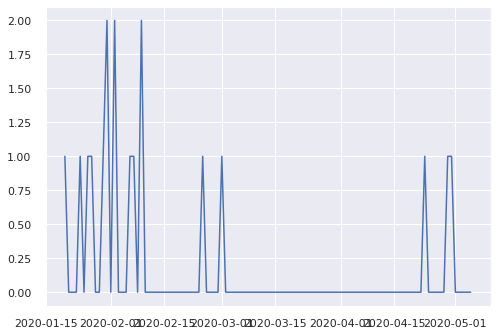

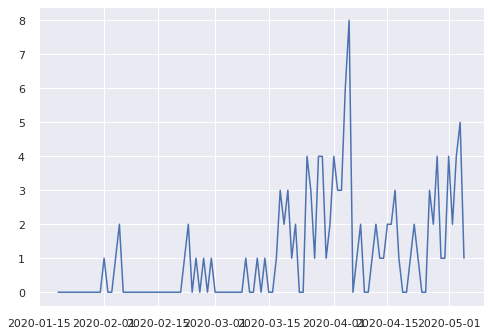

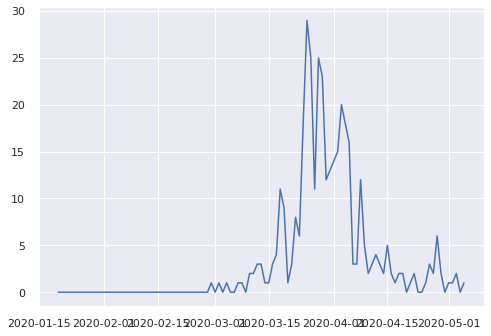

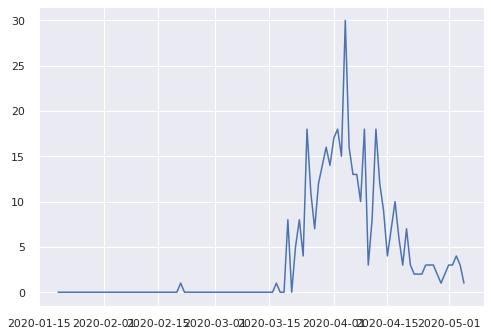

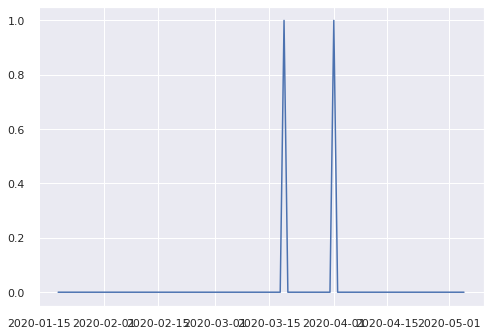

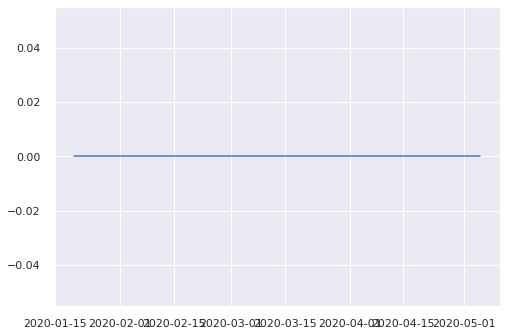

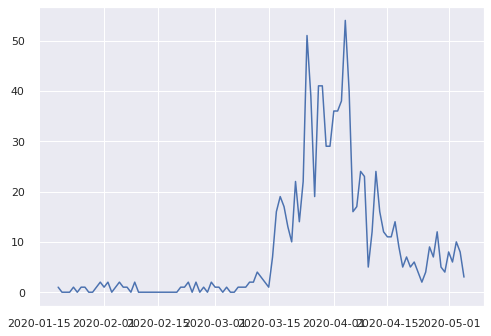

In [33]:
for col in kor_confirmed:
    plt.plot(kor_confirmed[col])
    plt.show()
    

In [95]:
kor_confirmed.to_pickle('./data_processed/E.Kor_confirmed/kor_confirmed.pkl')

# F. 대륙별 백만명당 확진자 수 데이터

In [96]:
#나라별 누적 확진자 수 데이터 불러오기
confirmed = pd.read_csv('./data_raw/FINAL_confirmed_0505.csv')
#나라-인구수 데이터 불러오기
country_population = pd.read_csv('./data_raw/country_population.txt')

In [97]:
#population dictionary 생성하기
dict_population = {}
for col in country_population.columns:
    dict_population[col] = country_population[col][0]

# F-1. 100만명당 누적 확진자 수

In [98]:
confirmed_accumulated = confirmed.copy()
#각 국가 100만명당 누적 확진자 수 구하기
for col in confirmed_accumulated.columns[3:]:
    confirmed_accumulated[col] = confirmed_accumulated[col].apply(lambda x: x / (dict_population[col]/1000000))

In [99]:
confirmed_accumulated.drop(['구분','합계'], axis=1, inplace=True)
confirmed_accumulated.set_index('날짜', inplace=True)

In [100]:
#위에서 생성한 나라-대륙 dict를 활용하여 대륙별 백만명당 누적 확진자 수 구함
confirmed_accumulated_million = confirmed_accumulated.rename(columns = world_dict)
confirmed_accumulated_million_continent = confirmed_accumulated_million.groupby(confirmed_accumulated_million.columns, axis=1).sum()
confirmed_accumulated_million_continent.head(3)

,미주,아프리카,유럽,중국,중국 외 아시아,호주
날짜,,,,,,
2020-01-21,0.000000,0.0,0.0,0.143328,0.036730,0.0
2020-01-22,0.000000,0.0,0.0,0.156163,0.036730,0.0
2020-01-23,0.003035,0.0,0.0,0.220340,0.079095,0.0


In [101]:
confirmed_accumulated_million_continent[50:70]

,미주,아프리카,유럽,중국,중국 외 아시아,호주
날짜,,,,,,
2020-03-11,9.983514,2.136178,2189.621610,57.600706,308.045580,4.632847
2020-03-12,15.606970,2.298936,2793.295486,57.611402,482.045779,5.421127
2020-03-13,18.539545,2.950683,3399.320704,57.617107,535.172234,5.421127
2020-03-14,26.318510,3.440540,4226.739645,57.633508,575.733661,6.524718
2020-03-15,42.920287,5.272496,4453.947092,57.647769,663.954947,8.972668
2020-03-16,42.397975,7.411426,5266.357730,57.659178,735.255372,11.022195
2020-03-17,61.092042,8.570087,6709.640319,57.674153,862.319201,12.953481
2020-03-18,92.723663,14.350955,7160.386301,57.683423,915.075351,16.995118
2020-03-19,119.117445,19.792430,9158.245576,57.707667,1013.904076,24.128174


In [102]:
#대륙별 백만명당 누적 확진자 수 저장
confirmed_accumulated_million_continent.to_pickle('./data_processed/B.Continent_confirmed/confirmed_accumulated_million_continent.pkl')

# F-2. 100만명당 신규 확진자 수

In [103]:
confirmed_new = confirmed.copy()
# (n)일자 누적확진자 - (n-1)일자 누적 확진자 = (n)일자 신규 확진자
for col in confirmed_new.columns[3:]:
    for i in range(len(confirmed_new)-1, 0, -1):
        confirmed_new[col][i] = confirmed_new[col][i] - confirmed_new[col][i-1]

confirmed_new['중국'][0] = 136 

In [104]:
confirmed_new['가이아나'][53:60]

53    1
54    5
55   -5
56    3
57    0
58    0
59    1
Name: 가이아나, dtype: int64

In [105]:
#각 국가 100만명당 일일 확진자 수 구하기
for col in confirmed_new.columns[3:]:
    confirmed_new[col] = confirmed_new[col].apply(lambda x: x / (dict_population[col]/1000000))


In [106]:
confirmed_new['가이아나'][55] = 0
confirmed_new.drop(['구분','합계'], axis=1, inplace=True)
confirmed_new.set_index('날짜', inplace=True)

In [107]:
#위에서 생성한 나라-대륙 dict를 활용하여 대륙별 백만명당 신규 확진자 수 구함
confirmed_new_million = confirmed_new.rename(columns = world_dict)
confirmed_new_million_continent = confirmed_new_million.groupby(confirmed_new_million.columns, axis=1).sum()
confirmed_new_million_continent.head(3)

,미주,아프리카,유럽,중국,중국 외 아시아,호주
날짜,,,,,,
2020-01-21,0.000000,0.0,0.0,0.096978,0.036730,0.0
2020-01-22,0.000000,0.0,0.0,0.012835,0.000000,0.0
2020-01-23,0.003035,0.0,0.0,0.064177,0.042365,0.0


In [108]:
#대륙별 백만명당 일일 확진자 수 저장
confirmed_new_million_continent.to_pickle('./data_processed/B.Continent_confirmed/confirmed_new_million_continent.pkl')

---
---
---
---

# <NLP 모델링>

# LDA 모델

### 함수 정의

In [109]:
def clean_datetime(date_col):
    from datetime import datetime

    date_col = date_col.apply(lambda x: datetime.strptime(datetime.strftime(x, format="%Y-%m-%d"), "%Y-%m-%d"))
    return date_col

In [110]:
#Corpus 만드는 함수
def make_corpus(text_col):
    from gensim import corpora
    dictionary = corpora.Dictionary(text_col)
    corpus = [dictionary.doc2bow(text) for text in text_col]
    return dictionary, corpus

In [111]:
#LDA 모델 훈련시키는 함수
def make_LDA(corpus, dictionary, num_topics, num_words):
    import gensim
    NUM_TOPICS = num_topics
    ldamodel = gensim.models.ldamodel.LdaModel(corpus, num_topics = NUM_TOPICS, id2word=dictionary, passes=15)
    topics = ldamodel.print_topics(num_words = num_words)

    return ldamodel, topics

In [112]:
#각 기사의 Topic 비중을 나타내는 dataframe을 생성하는 함수
def make_topictable_per_doc(ldamodel, corpus):
    topic_table = pd.DataFrame(columns = [str(x) for x in range(ldamodel.num_topics)])

    # 몇 번째 문서인지를 의미하는 문서 번호와 해당 문서의 토픽 비중을 한 줄씩 꺼내온다.
    for i, topic_list in enumerate(ldamodel[corpus]):
        doc = topic_list[0] if ldamodel.per_word_topics else topic_list            

        # 모든 문서에 대해서 각각 아래를 수행
        dict_topic_list = {}
        for j, (topic_num, prop_topic) in enumerate(doc): #  몇 번 토픽인지와 비중을 나눠서 저장한다.
            dict_topic_list[str(topic_num)] = prop_topic
        
        series_topic_list = pd.Series(dict_topic_list)
        topic_table = topic_table.append(dict_topic_list, ignore_index=True)
        
    return(topic_table)

In [113]:
#기존 covid 뉴스 dataframe과 Topic 정보를 나타내는 dataframe을 합치는 함수
def covid_concat(origin_df, topic_table):
    covid_topic= pd.concat([origin_df, topic_table], axis=1)
    return covid_topic

In [114]:
#각 날짜에 해당하는 모든 기사 Topic 정보 합치는 함수
def grouped_by_date(concat_df, num_topics):
    grouped_df = concat_df[[str(x) for x in range(num_topics)]].groupby(concat_df['게시날짜'])
    grouped_with_sum = grouped_df.sum()
    grouped_with_sum['합계'] = grouped_with_sum.sum(axis=1)
    return grouped_with_sum

In [115]:
def normalized_topic(topic_sum_df):
    for i in range(len(topic_sum_df)):
        topic_sum_df.iloc[i] = topic_sum_df.iloc[i] / topic_sum_df.iloc[i, -1]
    return topic_sum_df

### 실행

In [116]:
covid = pd.read_pickle('./data_processed/A.News_preprocessed/covid_ready_for_LDA.pkl')
covid.head(10)

,파일명,제목,URL,수집일자,게시날짜,채널명,감염병명,분류명,기사내용
0,ALJA2020011600003,China says Wuhan disease outbreak may be new c...,https://www.aljazeera.com/news/2020/01/chinese...,2020-01-16 13:00:06.0,2020-01-09,Al jazeera,COVID-19,Viral,"[authority, strain, caused, current, epidemic,..."
1,CIDA2020011600007,China to share with WHO new-type coronavirus' ...,http://en.nhc.gov.cn/2020-01/12/c_75969.htm,2020-01-16 16:00:28.0,2020-01-12,CIDARS (China Infectious Disease Automated Ale...,COVID-19,Viral,"[BEIJING, china, share, world, organization, W..."
2,CBCH2020011600020,Woman with new coronavirus quarantined in Thai...,https://www.cbc.ca/news/health/coronavirus-tha...,2020-01-16 13:22:35.0,2020-01-13,CBC,COVID-19,Viral,"[chinese, woman, quarantine, thailand, mystery..."
3,MEDI2020011900081,Indian school teacher in Shenzhen becomes firs...,https://medisys.newsbrief.eu/medisys/helsinkie...,2020-01-19 23:00:11.0,2020-01-13,MediSys,COVID-19,Viral,"[disease, glanders, location, turkey, horse, d..."
4,WHOD2020011800001,Novel Coronavirus – Thailand (ex-China),https://www.who.int/csr/don/14-january-2020-no...,2020-01-18 04:00:07.0,2020-01-14,WHO/DONs,COVID-19,Viral,"[ministry, labour, welfare, japan, MHLW, impor..."
5,ECDC2020011500001,Update: Cluster of pneumonia cases associated ...,https://www.ecdc.europa.eu/en/news-events/upda...,2020-01-16 15:00:17.0,2020-01-14,ECDC,COVID-19,Viral,"[onset, symptom, range, december, transmission..."
6,CBCH2020011600009,'Possible' there was limited human-to-human tr...,https://www.cbc.ca/news/health/china-virus-who...,2020-01-16 13:22:19.0,2020-01-14,CBC,COVID-19,Viral,"[limited, transmission, china, within, family,..."
7,GPHN2020011600036,China says human transmission not ruled out in...,https://gphin.canada.ca/cepr/showarticle.jsp?d...,2020-01-16 01:05:15.0,2020-01-15,GPHIN,COVID-19,Viral,"[fear, mount, across, asia, spread, identify, ..."
8,GPHN2020011600070,China coronavirus outbreak: five members of tw...,https://gphin.canada.ca/cepr/showarticle.jsp?d...,2020-01-16 04:01:53.0,2020-01-15,GPHIN,COVID-19,Viral,"[northern, KENTUCKY, experiencing, increase, w..."
9,GPHN2020011600028,US warns citizens in China against pneumonia o...,https://gphin.canada.ca/cepr/showarticle.jsp?d...,2020-01-16 01:04:14.0,2020-01-15,GPHIN,COVID-19,Viral,"[china, nji, vietnam, celebrate, nguy, feast, ..."


In [117]:
##num_topics, num_words 정하기
Num_Topics = 8
Num_Words = 10

In [118]:
##def 실행 - dictionary와 corpus 생성 , ldamodel, topic 생성
np.random.seed(100)
dictionary, corpus = make_corpus(covid['기사내용'])
ldamodel, topics = make_LDA(corpus, dictionary, Num_Topics, Num_Words)

In [119]:
####LDA모델이 잘 만들어졌는지 확인
for topic in tqdm(topics):
    print('{}번째 Topic'.format(topic[0]), topic[1])

100%|██████████| 8/8 [00:00<00:00, 9061.42it/s]

0번째 Topic 0.020*"death" + 0.012*"confirm" + 0.011*"ministry" + 0.010*"test" + 0.010*"minister" + 0.009*"government" + 0.008*"positive" + 0.008*"infection" + 0.007*"italy" + 0.007*"virus"
1번째 Topic 0.019*"virus" + 0.012*"death" + 0.009*"world" + 0.008*"outbreak" + 0.008*"spread" + 0.007*"pandemic" + 0.006*"WHO" + 0.006*"disease" + 0.005*"data" + 0.005*"rate"
2번째 Topic 0.061*"VIRGINIA" + 0.031*"test" + 0.022*"trump" + 0.017*"NEWYORK" + 0.016*"death" + 0.016*"US" + 0.010*"WASHINGTON" + 0.010*"american" + 0.009*"center" + 0.009*"CDC"
3번째 Topic 0.077*"china" + 0.031*"chinese" + 0.023*"wuhan" + 0.019*"province" + 0.013*"patient" + 0.013*"confirm" + 0.012*"hospital" + 0.011*"medical" + 0.009*"hubei" + 0.009*"outbreak"
4번째 Topic 0.020*"patient" + 0.012*"disease" + 0.010*"drug" + 0.010*"SARS" + 0.010*"study" + 0.009*"covV" + 0.009*"test" + 0.008*"vaccine" + 0.008*"virus" + 0.008*"infection"
5번째 Topic 0.018*"test" + 0.014*"hospital" + 0.013*"care" + 0.013*"patient" + 0.012*"home" + 0.008*"positi

In [120]:
covid.reset_index(inplace=True)

In [121]:
##def 실행 - 각 기사별로 topic 비중 확인하기
topictable = make_topictable_per_doc(ldamodel, corpus)
covid_topic_df = covid_concat(covid['게시날짜'], topictable)

In [122]:
####covid_topic 잘 만들어졌는지 확인
covid_topic_df.head()

,게시날짜,0,1,2,3,4,5,6,7
0,2020-01-09,NaN,0.365620,NaN,0.359472,0.269108,NaN,NaN,NaN
1,2020-01-12,NaN,NaN,NaN,0.417159,0.218018,NaN,0.337626,NaN
2,2020-01-13,0.046260,0.358464,NaN,0.426247,0.108301,NaN,0.058238,NaN
3,2020-01-13,0.361788,NaN,0.086853,0.109916,0.241738,0.037697,NaN,0.154846
4,2020-01-14,NaN,NaN,NaN,0.408017,0.391577,0.177279,0.021193,NaN


In [123]:
covid_topic_df['게시날짜'] = clean_datetime(covid_topic_df['게시날짜'])

##def 실행 - 날짜 기준으로 기사의 topic 정보 합침
grouped_with_sum = grouped_by_date(covid_topic_df, Num_Topics)

In [124]:
####grouped_with_sum 잘 만들어졌는지 확인
grouped_with_sum

,0,1,2,3,4,5,6,7,합계
게시날짜,,,,,,,,,
2020-01-09,0.000000,0.365620,0.000000,0.359472,0.269108,0.000000,0.000000,0.000000,0.994199
2020-01-12,0.000000,0.000000,0.000000,0.417159,0.218018,0.000000,0.337626,0.000000,0.972803
2020-01-13,0.408049,0.358464,0.086853,0.536164,0.350039,0.037697,0.058238,0.154846,1.990349
2020-01-14,0.171830,0.589587,0.000000,1.126933,0.810938,0.224129,0.068795,0.000000,2.992212
2020-01-15,2.646131,8.777371,0.800937,11.481286,13.543593,9.511173,2.217261,1.688445,50.666198
...,...,...,...,...,...,...,...,...,...
2020-05-02,75.276617,50.083537,19.875043,34.488928,43.372378,65.056942,30.037551,60.944209,379.135204
2020-05-03,83.420959,49.649956,28.348240,23.031755,32.858635,63.668643,25.356868,70.576088,376.911146
2020-05-04,123.309935,82.845190,25.291176,32.049030,68.431574,102.363167,62.501749,161.421111,658.212933


In [125]:
##def 실행 - normalizing
covid_topic_normalized = normalized_topic(grouped_with_sum)
covid_topic_normalized.reset_index(inplace=True)
covid_topic_normalized.head()

,게시날짜,0,1,2,3,4,5,6,7,합계
0,2020-01-09,0.000000,0.367753,0.000000,0.361569,0.270678,0.000000,0.000000,0.000000,1.0
1,2020-01-12,0.000000,0.000000,0.000000,0.428822,0.224113,0.000000,0.347065,0.000000,1.0
2,2020-01-13,0.205014,0.180101,0.043637,0.269382,0.175868,0.018940,0.029260,0.077798,1.0
3,2020-01-14,0.057426,0.197041,0.000000,0.376622,0.271016,0.074904,0.022992,0.000000,1.0
4,2020-01-15,0.052227,0.173239,0.015808,0.226606,0.267310,0.187722,0.043762,0.033325,1.0


In [126]:
# topic 컬럼 정리
columns = ["date"] + ["Topic_{}".format(i) for i in range(Num_Topics)] + ['합계']
covid_topic_normalized.columns = columns

In [127]:
covid_topic_normalized.head()
covid_topic_normalized.to_pickle('./data_processed/covid_topic_normalized.pkl')

-----
_____

# <최종 데이터 만들기> 

In [128]:
#일자별 토픽 비중 데이터 불러오기
topics = pd.read_pickle('./data_processed/covid_topic_normalized.pkl')
topics.drop('합계', axis=1, inplace=True)
topics['date'] = pd.to_datetime(topics['date'])
topics.set_index('date', drop = True, inplace = True)

#입국자 수 데이터 불러오기
inbound = pd.read_pickle('./data_processed/C.Inbound/final_daily_inbound_continent.pkl')
inbound.drop('합계', axis=1, inplace = True)
inbound.columns= ['date','America_ent','Africa_ent','Europe_ent','China_ent','Asia_out_china_ent','Australia_ent']
inbound['date'] = pd.to_datetime(inbound['date'])
inbound.set_index('date', drop = True, inplace = True )

#대륙별 유입 확진자 데이터 불러오기
continent_confirmed = pd.read_pickle('./data_processed/B.Continent_confirmed/continent_new_confirmed.pkl')
continent_confirmed.columns= ['date','America_confirmed','Africa_confirmed','Europe_confirmed','China_confirmed','Asia_out_china_confirmed','Australia_confirmed']
continent_confirmed['date'] = pd.to_datetime(continent_confirmed['date'])
continent_confirmed.set_index('date', drop = True, inplace = True)

#기사 개수
articles = pd.read_pickle('./data_processed/A.News/covid_news_wo_garbage.pkl')
art_count = articles.groupby('게시날짜')[['기사내용']].count()
art_count.index.names = ['date']
art_count.rename(columns = {'기사내용':'art_count'}, inplace = True)

#해외 유입 확진자 수 데이터 불러오기
kor_confirm = pd.read_pickle('./data_processed/E.Kor_confirmed/kor_confirmed.pkl')
kor_confirm.drop('Daily_confirmed_kor', axis=1, inplace = True)
kor_confirm.columns= ['date','China_유입','Asia_out_china_유입','Europe_유입','America_유입','Africa_유입','Australia_유입']
kor_confirm['date'] = pd.to_datetime(kor_confirm['date'])
kor_confirm.set_index('date', drop = True, inplace = True)

In [129]:
#하나의 데이터프레임으로 합치기
topic_art = topics.merge(art_count,left_index=True, right_index=True, how='outer')
topic_art_inbound = topic_art.merge(inbound, left_index=True, right_index=True, how='outer')
topic_art_inbound_continent = topic_art_inbound.merge(continent_confirmed, left_index=True, right_index=True, how='outer')
final = topic_art_inbound_continent.merge(kor_confirm, left_index=True, right_index=True, how='outer')

#final 데이터 저장
final.to_pickle('./data_processed/final.pkl')

---
---

# < Feature Engineering >

# 1-1. 최종 데이터 불러오기

In [132]:
acc_confirmed_per_million = pd.read_pickle('./data_processed/B.Continent_confirmed/confirmed_accumulated_million_continent.pkl')

#백만명 당 확진자 수가 5인 시점 찾기
print('아래의 시점 (백만명 당 확진자 수가 5인 시점) 이후부터 모델을 학습시킬 것이다')
print('-'*75)
for col in acc_confirmed_per_million.columns:
    date = acc_confirmed_per_million[acc_confirmed_per_million[col] >= 5].index[0]
    print("col name: {} - ".format(col), date)

아래의 시점 (백만명 당 확진자 수가 5인 시점) 이후부터 모델을 학습시킬 것이다
---------------------------------------------------------------------------
col name: 미주 -  2020-03-09
col name: 아프리카 -  2020-03-15
col name: 유럽 -  2020-02-26
col name: 중국 -  2020-01-31
col name: 중국 외 아시아 -  2020-01-28
col name: 호주 -  2020-03-12


In [133]:
final = pd.read_pickle("./data_processed/final.pkl")
final = final.dropna().reset_index()
final.rename(columns = {'date':'Date', 'art_count':'Art_count'}, inplace=True)
#컬럼 순서 재배열
final = final[['Date', 'Topic_0', 'Topic_1', 'Topic_2', 'Topic_3', 'Topic_4','Topic_5', 'Topic_6', 'Topic_7', 'Art_count', 
               'America_ent', 'Africa_ent','Europe_ent', 'China_ent', 'Asia_out_china_ent', 'Australia_ent',
               'America_confirmed', 'Africa_confirmed', 'Europe_confirmed','China_confirmed', 'Asia_out_china_confirmed', 'Australia_confirmed',
               'America_유입', 'Africa_유입', 'Europe_유입', 'China_유입','Asia_out_china_유입', 'Australia_유입']]

In [134]:
nation_name = ['america','africa','europe','china','asia','austrailia']
nation_name_tuple = [('america_train_df','america_test_df'),
               ('africa_train_df','africa_test_df'),
               ('europe_train_df','europe_test_df'),
               ('china_train_df','china_test_df'),
               ('asia_train_df','asia_test_df'),
               ('austrailia_train_df','austrailia_test_df')]

# 1-2. 대륙별 최종 데이터프레임 생성

In [135]:
# 미주 2020-03-09 이후 사용.
america = final[['Date', 'Topic_0', 'Topic_1', 'Topic_2', 'Topic_3', 'Topic_4','Topic_5', 'Topic_6', 'Topic_7', 
                 'Art_count', 'America_ent','America_confirmed', 'America_유입']]

# 아프리카 2020-03-15 이후 사용.
africa = final[['Date', 'Topic_0', 'Topic_1', 'Topic_2', 'Topic_3', 'Topic_4','Topic_5', 'Topic_6', 'Topic_7', 
                'Art_count', 'Africa_ent','Africa_confirmed', 'Africa_유입']]

# 유럽 2020-02-26 이후 사용.
europe = final[['Date', 'Topic_0', 'Topic_1', 'Topic_2', 'Topic_3', 'Topic_4','Topic_5', 'Topic_6', 'Topic_7',
                'Art_count', 'Europe_ent', 'Europe_confirmed', 'Europe_유입']]

# 중국 2020-01-31 이후 사용.
china = final[['Date', 'Topic_0', 'Topic_1', 'Topic_2', 'Topic_3', 'Topic_4','Topic_5', 'Topic_6', 'Topic_7', 
               'Art_count', 'China_ent','China_confirmed', 'China_유입']]

# 중국 외 아시아 2020-01-28 이후 사용.
asia = final[['Date', 'Topic_0', 'Topic_1', 'Topic_2', 'Topic_3', 'Topic_4', 'Topic_5', 'Topic_6', 'Topic_7', 
              'Art_count', 'Asia_out_china_ent', 'Asia_out_china_confirmed', 'Asia_out_china_유입']]

# 호주 2020-03-12 이후 사용.
austrailia = final[['Date', 'Topic_0', 'Topic_1', 'Topic_2', 'Topic_3', 'Topic_4', 'Topic_5', 'Topic_6', 'Topic_7', 
                    'Art_count', 'Australia_ent', 'Australia_confirmed', 'Australia_유입']]

# 1-3. 상관계수

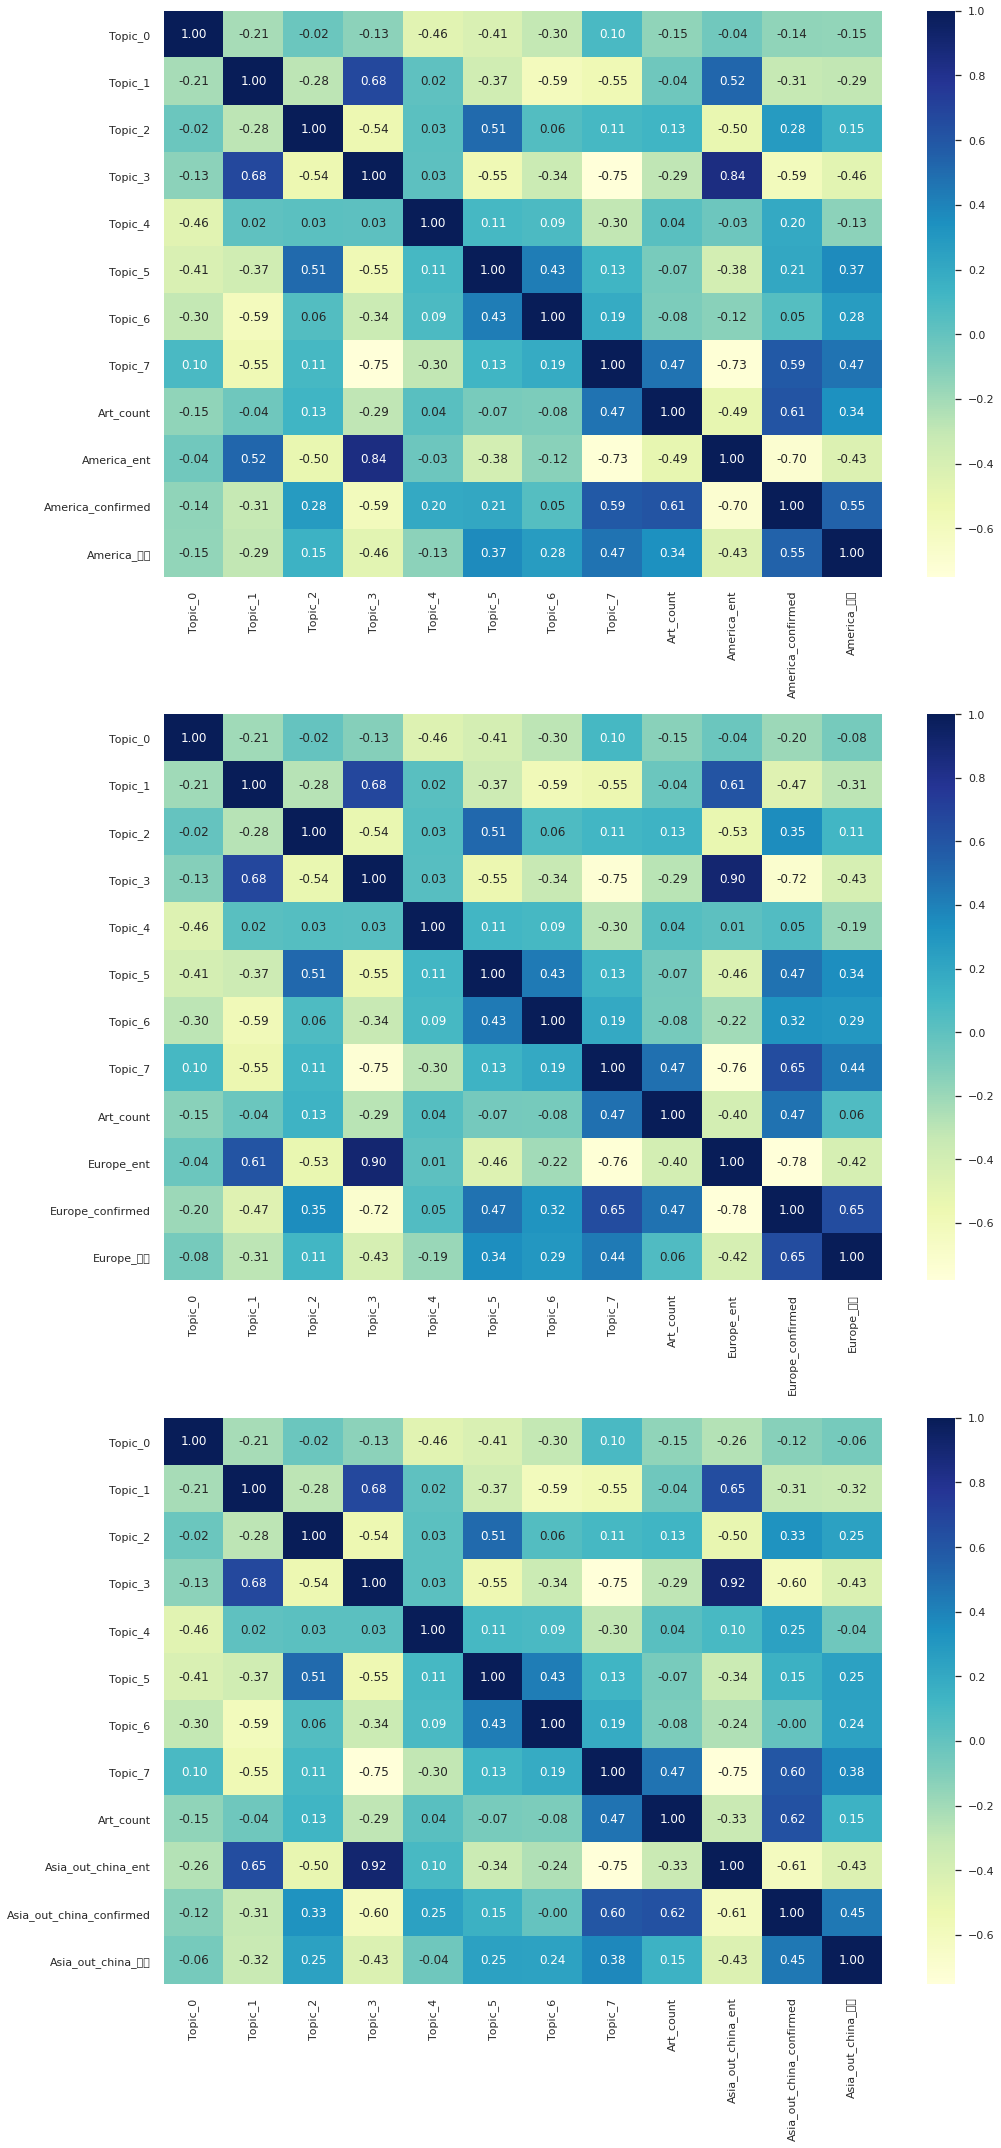

In [178]:
corr_data_america = america.corr()
corr_data_europe = europe.corr()
corr_data_asia = asia.corr()

fig, ax = plt.subplots(3, 1, figsize=(15,30))

sns.heatmap(data=corr_data_america, annot=True, fmt='.2f', cmap='YlGnBu', ax=ax[0])
sns.heatmap(data=corr_data_europe, annot=True, fmt='.2f', cmap='YlGnBu', ax=ax[1])
sns.heatmap(data=corr_data_asia, annot=True, fmt='.2f', cmap='YlGnBu', ax=ax[2])

plt.tight_layout()
plt.show()

## 2. feature 생성

1. lag 1~14인 것 주기.
2. 요일별 특성을 주기.


1. lag: 1~ 14
2. rolling: target

In [136]:
def feature_eng(data_frame):
    
    date = data_frame.iloc[:, 0] # date column
    features = data_frame.iloc[:, 1:-1] # date 제외. target column을 활용한 lag + rolling(mean, std) 포함.
    new_features = pd.DataFrame()
    
    target = data_frame.iloc[:, -1] # target column
    target_rolling = pd.DataFrame()
    
    # 5월 6일 이후의 데이터 생성.
    # test set으로 활용.
    after_may5_date_col = pd.date_range('2020-05-06', periods=14)
    after_may5_input_data = pd.DataFrame(index=after_may5_date_col).reset_index()
    after_may5_input_data.columns = ["Date"]
    
    # lag
    for col_name in features.columns:
        for lag in range(0, 15): # 1~14까지 lag를 바꿔서 특성 추출.
            zero_col_name = col_name + '_lag_0'
            new_col_name = col_name + '_lag_{}'.format(lag)
            new_features[new_col_name] = features[col_name].transform(lambda x: x.shift(lag))
            if lag >= 1:
                after_may5_input_data[new_col_name] = float(new_features[zero_col_name].iloc[-1])
                after_may5_input_data[new_col_name][:lag] = new_features.iloc[:,0][-lag:].values

            else:
                after_may5_input_data[new_col_name] = float(new_features[zero_col_name].iloc[-1])
            
    # target_rolling
    for i in [7, 14]: # 7일과 14일의 평균, 편차를 반영.
        new_col_name_mean = target.name + '_rolling_{}_mean'.format(i)
        new_col_name_std = target.name + '_rolling_{}_std'.format(i)
        target_rolling[new_col_name_mean] = target.rolling(i).mean()
        target_rolling[new_col_name_std] = target.rolling(i).std()
        after_may5_input_data[new_col_name_mean] = target_rolling[new_col_name_mean].iloc[-1]
        after_may5_input_data[new_col_name_std] = target_rolling[new_col_name_std].iloc[-1]
        
    result = pd.concat([date, new_features, target_rolling, target], axis=1)
        
    return result, after_may5_input_data

In [137]:
from sklearn.preprocessing import MinMaxScaler

min_max = MinMaxScaler()

for name in nation_name:
    train_df, test_df = feature_eng(eval(name))
    
    
    
    if name == 'america':
        train_df = train_df[train_df['Date'] >= '2020-03-09'].reset_index(drop=True)
    elif name == 'africa':
        train_df = train_df[train_df['Date'] >= '2020-03-15'].reset_index(drop=True)
    elif name == 'europe':
        train_df = train_df[train_df['Date'] >= '2020-02-26'].reset_index(drop=True)
    elif name == 'china':
        train_df = train_df[train_df['Date'] >= '2020-01-31'].reset_index(drop=True)
    elif name == 'asia':
        train_df = train_df[train_df['Date'] >= '2020-01-28'].reset_index(drop=True)
    elif name == 'austrailia':
        train_df = train_df[train_df['Date'] >= '2020-03-12'].reset_index(drop=True)
    
    # Topic, target, Date columns를 제외한 나머지를 각각의 column에 대해 min_max scaling. 
    train_scale_df = train_df.iloc[:, 121:-1] # 유입 특성 제외시 -5로 slicing.
    test_scale_df = test_df.iloc[:, 121:] # 유입 특성 제외시 -4로 slicing.
    
    # fit, transform
    min_max.fit(train_scale_df)
    train_scale_df = pd.DataFrame(min_max.transform(train_scale_df), columns=train_scale_df.columns)
    test_scale_df = pd.DataFrame(min_max.transform(test_scale_df), columns=train_scale_df.columns)
    
    # 다시 train_df, test_df에 넣어줌.
    train_df[train_scale_df.columns] = train_scale_df
    test_df[test_scale_df.columns] = test_scale_df
    
    # 각 대륙별로 데이터 프레임 저장.
    
    train_df.to_pickle("./data_processed/Z.Train_test/{}_train.pkl".format(name))
    test_df.to_pickle("./data_processed/Z.Train_test/{}_test.pkl".format(name))

# < 모델링 >

#### Train


1. 미주: america_train.pkl
2. 유럽: europe_train.pkl
3. 중국 외 아시아: asia_train.pkl


#### Test

1. 미주: america_test.pkl
2. 유럽: europe_test.pkl
3. 중국 외 아시아: asia_test.pkl


<br>

#### 활용 모델


1. XGBoosting( x )
2. GradientBoosting( x )
3. RandomForest( o )


# 1. Train, Test 분리: 미주, 유럽, 중국 외 아시아

In [138]:
# Data Load
# 해외유입 누적 확진자 수(총 1,118명)에서 약 3개월 간 중국(19명), 아프리카(3명), 호주(0명)으로
# 해당 대륙에 대한 예측에 다소 무리가 있고, 전체 해외유입에 영향력이 크지 않다고 판단.
# 미주, 유럽, 중국 외 아시아에 대해서 적합한 모델을 만든 후, 결괏값을 합산하여 최종 submission을 구성.


# 미주
america_train = pd.read_pickle("./data_processed/Z.Train_test/america_train.pkl")
america_test = pd.read_pickle("./data_processed/Z.Train_test/america_test.pkl")

# 유럽
europe_train = pd.read_pickle("./data_processed/Z.Train_test/europe_train.pkl")
europe_test = pd.read_pickle("./data_processed/Z.Train_test/europe_test.pkl")

# 중국 외 아시아
asia_train = pd.read_pickle("./data_processed/Z.Train_test/asia_train.pkl")
# NaN 값 제거 후 2월 4일부터 사용.
asia_train = asia_train.dropna()
asia_test = pd.read_pickle("./data_processed/Z.Train_test/asia_test.pkl")

In [139]:
# 데이터 크기 확인.
print(america_train.shape)
print(america_test.shape)
print(europe_train.shape)
print(europe_test.shape)
print(asia_train.shape)
print(asia_test.shape)

(58, 171)
(14, 170)
(70, 171)
(14, 170)
(92, 171)
(14, 170)


In [140]:
######## train 데이터에 대한 수가 적기 때문에 train을 train set, validation set으로 나누는 것은 부적합.
# 5월 5일까지의 데이터를 train으로, 5월 6일 ~ 5월 10일까지의 target 값을 test로 하여 가장 잘 맞는 모델을 선택.

# X_train set: 미주, 유럽, 중국 외 아시아
X_train_america = america_train.drop(['Date', 'America_유입'], axis=1)
X_train_europe = europe_train.drop(['Date', 'Europe_유입'], axis=1)
X_train_asia = asia_train.drop(['Date', 'Asia_out_china_유입'], axis=1)

# y_train set: 미주, 유럽, 중국 외 아시아
y_train_america = america_train['America_유입']
y_train_europe = europe_train['Europe_유입']
y_train_asia = asia_train['Asia_out_china_유입']

# X_test set(5월6일~5월19일까지의 input data): 미주, 유럽, 중국 외 아시아.
# 5월 6일부터 5월 19까지 target 값을 예측하는데 사용.

X_test_america = america_test.drop('Date', axis=1)
X_test_europe = europe_test.drop('Date', axis=1)
X_test_asia = asia_test.drop('Date', axis=1)

# 2. 활용할 함수 정의

In [141]:
# metric 정의
# 포스트 코로나 챌린지 평가 함수.

def post_corona_metric(data_frame):
    import numpy as np
    
    prediction = data_frame['pred'].values
    actual = data_frame['actual'].values
    
    diff = np.square(prediction - actual).sum()
    
    over = np.square(actual).sum()
    
    return 100 * (1 - diff/over)

In [142]:
# trend를 반영한 확진자 예측.
# Hodrick Prescott Filter 활용.

def get_target_series(target_series, lamb=1600):
    
    import statsmodels.api as sm
    import matplotlib.pyplot as plt
    import math
    
    # target에 대한 
    cycle, trend = sm.tsa.filters.hpfilter(target_series, lamb=lamb)

    target_df = pd.DataFrame(target_series)
    target_df.columns = ['target']
    target_df["cycle"] = cycle
    target_df["trend"] = trend
    
    # trend값이 음수인 것은 0으로 치환.
    target_df[target_df['trend'] <= 0] = 0
    
    return target_df['trend'].round() # '기존 target 값', 'cycle', 'trend' / 기존 target 대신 trend 값을 활용.

In [143]:
# 타겟 데이터.
# target 값의 trend를 새로운 target 값으로 지정.

y_train_america_trend = get_target_series(y_train_america)
y_train_europe_trend = get_target_series(y_train_europe)
y_train_asia_trend = get_target_series(y_train_asia)

# 3. Prediction

In [144]:
# X_train: 각 대륙별 데이터. target 제외한 나머지 컬럼.
# y_train: X_train에 대한 target 값.
# X_test: 5월 6일 ~ 19일까지의 input data.

# 각 대륙별 유입 확진자의 'trend'를 'target'으로 학습.

def rf_model(X_train, y_train, X_test):

    X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, random_state=6)

    forest = RandomForestRegressor(n_estimators=6, random_state=1, bootstrap=True)
    forest.fit(X_train, y_train)

    print("훈련 세트 정확도: {:.3f}".format(forest.score(X_train, y_train)))
    print("검증 세트 정확도: {:.3f}".format(forest.score(X_valid, y_valid)))

    result_valid = pd.DataFrame({'pred':forest.predict(X_valid).round(), 'actual':y_valid})

    print("metric score: '{:.2f}'".format(post_corona_metric(result_valid)))
    
    # 5월 6일 ~ 5월 19일 데이터로 뽑은 prediction 값.
    result = pd.Series(forest.predict(X_test)).round()

    return result

# 4. 평가

In [147]:
result_america = rf_model(X_train_america, y_train_america_trend, X_test_america)
result_europe = rf_model(X_train_europe, y_train_europe_trend, X_test_europe)
result_asia = rf_model(X_train_asia, y_train_asia_trend, X_test_asia)

# 각 데이터에 대한 결과.
each_result = pd.DataFrame({'america': result_america, 'europe': result_europe, 'asia': result_asia})
each_result.index = pd.date_range('2020-05-06', periods=14)

# 최종 결과
pred_result = result_america + result_europe + result_asia
pred_result.index = pd.date_range('2020-05-06', periods=14)

훈련 세트 정확도: 0.961
검증 세트 정확도: 0.885
metric score: '94.63'
훈련 세트 정확도: 0.962
검증 세트 정확도: 0.869
metric score: '95.27'


ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:33653)
Traceback (most recent call last):
  File "/dsvm/tools/spark/current/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 929, in _get_connection
    connection = self.deque.pop()
IndexError: pop from an empty deque

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/dsvm/tools/spark/current/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 1067, in start
    self.socket.connect((self.address, self.port))
ConnectionRefusedError: [Errno 111] Connection refused
ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:33653)
Traceback (most recent call last):
  File "/dsvm/tools/spark/current/python/lib/py4j-0.10.7-src.zip/py4j/java_gateway.py", line 929, in _get_connection
    connection = self.deque.pop()
IndexError: pop from an empty deque

During handling of the above e

훈련 세트 정확도: 0.969
검증 세트 정확도: 0.833
metric score: '92.16'


In [148]:
# 5월 6일부터 5월 19일까지 각 일자별 해외 유입 확진자 예측값('sum' column)

each_result.merge(pd.DataFrame(pred_result, columns=['sum']), left_index=True, right_index=True)

,america,europe,asia,sum
2020-05-06,4.0,2.0,1.0,7.0
2020-05-07,5.0,2.0,1.0,8.0
2020-05-08,4.0,2.0,2.0,8.0
2020-05-09,3.0,1.0,1.0,5.0
2020-05-10,3.0,1.0,1.0,5.0
2020-05-11,3.0,1.0,1.0,5.0
2020-05-12,3.0,1.0,1.0,5.0
2020-05-13,3.0,1.0,2.0,6.0
2020-05-14,2.0,1.0,2.0,5.0
2020-05-15,3.0,1.0,2.0,6.0


---
---
---

# < 시각화 >

In [149]:
# --- plotly ---
from plotly import tools, subplots
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px
import plotly.figure_factory as ff
import plotly.io as pio

# A. 뉴스 데이터

## A-1. 기사 개수 시각화

In [150]:
art_count_0505 = art_count[:-1]
fig = px.line(art_count_0505, x=art_count_0505.index, y = art_count_0505['art_count'])
fig.update_layout(
    title="Topic Count", title_x=0.5,
    xaxis_title="Date")
fig.show()

## A-2. 기사 토픽 시각화

In [153]:
import plotly.express as px
import plotly.graph_objects as go
normalized_df = pd.read_pickle('./data_processed/covid_topic_normalized.pkl')

trace0 = go.Scatter(x = normalized_df['date'], y = normalized_df['Topic_0'],
                   mode = 'lines', name = 'Topic 1')
trace1 = go.Scatter(x = normalized_df['date'], y = normalized_df['Topic_1'],
                   mode = 'lines', name = 'Topic 2')
trace2 = go.Scatter(x = normalized_df['date'], y = normalized_df['Topic_2'],
                   mode = 'lines', name = 'Topic 3')
trace3 = go.Scatter(x = normalized_df['date'], y = normalized_df['Topic_3'],
                   mode = 'lines', name = 'Topic 4')
trace4 = go.Scatter(x = normalized_df['date'], y = normalized_df['Topic_4'],
                   mode = 'lines', name = 'Topic 5')
trace5 = go.Scatter(x = normalized_df['date'], y = normalized_df['Topic_5'],
                   mode = 'lines', name = 'Topic 6')
trace6 = go.Scatter(x = normalized_df['date'], y = normalized_df['Topic_6'],
                   mode = 'lines', name = 'Topic 7')
trace7 = go.Scatter(x = normalized_df['date'], y = normalized_df['Topic_7'],
                   mode = 'lines', name = 'Topic 8')

topics_trace = [trace0, trace1, trace2, trace3, trace4, trace5, trace6, trace7]
figure = go.Figure(data=topics_trace)
figure.update_layout(
    title="Topic Trend", title_x=0.5,
    xaxis_title="Date")

figure.show()

In [154]:
!pip install pyLDAvis

## A-3. 뉴스 기사 토픽 구성 단어

In [155]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)
pyLDAvis.display(vis)

# B.국외 코로나 발생현황 데이터 시각화

## B-1-1. 대륙별 누적 확진자 수

In [156]:
# 데이터 불러오기
confirmed_acc = pd.read_pickle('./data_processed/B.Continent_confirmed/continent_acc_confirmed.pkl')
#대륙별 누적 확진자 수 시각화
df_confirmed_acc = pd.melt(confirmed_acc, id_vars=['날짜'], value_vars=confirmed_acc.columns[1:])

fig = px.line(df_confirmed_acc, x='날짜', y="value", color='variable',title="대륙별 누적 발생 확진자수")
fig.show()

## B-1-2. 대륙별 백만명 당 누적 확진자 수

In [157]:
pd.read_pickle('./data_processed/B.Continent_confirmed/confirmed_accumulated_million_continent.pkl')

,미주,아프리카,유럽,중국,중국 외 아시아,호주
날짜,,,,,,
2020-01-21,0.000000,0.000000,0.000000,0.143328,0.036730,0.000000
2020-01-22,0.000000,0.000000,0.000000,0.156163,0.036730,0.000000
2020-01-23,0.003035,0.000000,0.000000,0.220340,0.079095,0.000000
2020-01-24,0.003035,0.000000,0.000000,0.407165,1.739883,0.000000
2020-01-25,0.003035,0.000000,0.000000,0.591852,3.577709,0.000000
...,...,...,...,...,...,...
2020-05-01,13482.609696,3085.251266,95801.790563,59.095310,21685.669947,514.489355
2020-05-02,13968.909121,3254.795474,96655.924556,59.096023,22936.393578,515.724034
2020-05-03,14485.778166,3374.612705,97720.261222,59.097449,23853.648717,516.323808


In [158]:
confirmed_acc_million = pd.read_pickle('./data_processed/B.Continent_confirmed/confirmed_accumulated_million_continent.pkl')
confirmed_acc_million.reset_index(inplace=True)
#대륙별 백만명 당 누적 확진자 수 시각화
df_confirmed_acc_million = pd.melt(confirmed_acc_million, id_vars=['날짜'], value_vars=confirmed_acc_million.columns[1:])

fig = px.line(df_confirmed_acc_million, x='날짜', y="value", color='variable',title="대륙별 백만명 당 누적 발생 확진자수")
fig.show()

## B-2-1. 대륙별 신규 확진자 수

In [159]:
# 데이터 불러오기
confirmed_new = pd.read_pickle('./data_processed/B.Continent_confirmed/continent_new_confirmed.pkl')
#대륙별 신규 확진자 수 시각화
df_confirmed_new = pd.melt(confirmed_new, id_vars=['날짜'], value_vars=confirmed_new.columns[1:])

fig = px.line(df_confirmed_new, x='날짜', y="value", color='variable',title="대륙별 신규 발생 확진자수")
fig.show()

## B-2-2. 대륙별 백만명 당 신규 확진자 수

In [160]:
confirmed_new_million = pd.read_pickle('./data_processed/B.Continent_confirmed/confirmed_new_million_continent.pkl')
confirmed_new_million.reset_index(inplace = True)
#대륙별 백만명 당 누적 확진자 수 시각화
df_confirmed_new_million = pd.melt(confirmed_new_million, id_vars=['날짜'], value_vars=confirmed_new_million.columns[1:])

fig = px.line(df_confirmed_new_million, x='날짜', y="value", color='variable',title="대륙별 백만명 당 신규 발생 확진자수")
fig.show()

# C. 해외 입국자 데이터 시각화

## C-1. 출국지 대륙별 입국자수

In [161]:
inbound_plot = pd.read_pickle('./data_processed/C.Inbound/final_daily_inbound_continent.pkl')

# 해외 입국자 데이터 시각화
df_inbound = pd.melt(inbound_plot, id_vars=['날짜'], value_vars=inbound_plot.columns.tolist()[1:])

fig = px.line(df_inbound, x="날짜", y="value", color='variable',
              title="날짜별 유입국가(방문지역)별 입국자수 \n")
fig.show()

## C-D. 미주 기준 해외 입국자와 로밍 데이터 비교

In [162]:
roaming_plot = pd.read_pickle('./data_processed/D.Roaming/roaming_continent.pkl')
roaming_plot.drop(roaming_plot.index[:31], inplace=True)

inbound = go.Scatter(x = inbound_plot['날짜'], y = inbound_plot['미주'],
                   mode = 'lines', name = '미주 입국자')
roaming = go.Scatter(x = roaming_plot['날짜'], y = roaming_plot['미주'],
                     mode = 'lines', name = '미주 로밍 이용자')

traces = [inbound, roaming]
figure = go.Figure(data=traces)
figure.update_layout(
    title="America: Inbound vs. Roaming", title_x=0.5,
    xaxis_title="Date")

figure.show()

# E. 국내 해외유입 확진자 수 데이터 시각화

In [163]:
kor_confirmed_plot = pd.read_pickle('./data_processed/E.Kor_confirmed/kor_confirmed.pkl')
kor_confirmed_plot

# 시각화
df_k_confirmed = pd.melt(kor_confirmed_plot, id_vars = ['Date'], value_vars = kor_confirmed_plot.columns.tolist()[1:])
fig = px.line(df_k_confirmed, x="Date", y="value", color='variable',title="날짜별 해외유입 확진자 수")
fig.show()

# 미주 대표 시각화

In [164]:
inbound_for_final = inbound_plot[20:].reset_index(drop = True)
america_confirmed_new_million = go.Scatter(x = confirmed_new_million['날짜'], y = confirmed_new_million['미주'],
                     mode = 'lines', name = '미주 백만명 당 신규 확진자')
america_inbound = go.Scatter(x = inbound_for_final['날짜'], y = inbound_for_final['미주']/10,
                     mode = 'lines', name = '미주 입국자')
america_kor_confirmed = go.Scatter(x = kor_confirmed_plot['Date'], y = kor_confirmed_plot['Americas_kor']*10,
                     mode = 'lines', name = '국내 미주발 해외유입 확진자')

traces = [america_confirmed_new_million, america_inbound, america_kor_confirmed]
figure = go.Figure(data=traces)
figure.update_layout(
    title="America: New confirmed vs. Inbound vs. Korea confirmed", title_x=0.5,
    xaxis_title="Date")

figure.show()